In [1]:
import time

start_time = time.time()

In [2]:
import math
import os
import sys
import warnings
from datetime import datetime

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "_0_Constants_and_Utils"))


from database_utils import form_connection_params, get_dataframe_from_query
from viz_constants import (
    COMPANY_ID_TO_NAME,
    COMPANY_NAME_TO_ID,
    DTYPES_CONVERSATIONS,
    DTYPES_CONVERSATIONS_CATEGORY,
    DTYPES_USERS,
    QUERY_CONVERSATIONS_CATEGORY,
    QUERY_USERS,
)
from viz_helpers import get_country_name, get_full_language_name

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)


# Loading

In [3]:
start_date = "2019-06-06"
end_date = "2020-02-02"
start_date_sql = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y-%m-%d')
end_date_sql = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y-%m-%d')

In [4]:
# Set local = False if you want to query the online MySQL database
local = True
connection_params = form_connection_params(local, True)

In [5]:
df_users = get_dataframe_from_query(QUERY_USERS, connection_params, local, DTYPES_USERS, "user_id", parse_dates=["creation_time"])

In [6]:
query_tweets_vis =f"""
Select
    tweet_id, user_id, lang, creation_time, country_code,
    favorite_count, retweet_count, possibly_sensitive,
    reply_count, quote_count, sentiment_score
from Tweets
where tweet_id in (select tweet_id from Conversations)
AND creation_time BETWEEN '{start_date_sql}' AND '{end_date_sql}';
"""


dtypes_tweets_vis = {
    "tweet_id": "object",
    "user_id": "object",
    "lang": "category",
    "creation_time": "datetime64[ns]",
    "country_code": "category",
    "favorite_count": "int32",
    "retweet_count": "int32",
    "possibly_sensitive": "bool",
    "reply_count": "int32",
    "quote_count": "int32",
    "sentiment_score": "float32"
}
df_tweets = get_dataframe_from_query(query_tweets_vis, connection_params, local, dtypes_tweets_vis, "tweet_id", parse_dates=["creation_time"])
# df_tweets["lang"] = df_tweets["lang"].apply(get_full_language_name)
# df_tweets["country_code"] = df_tweets["country_code"].apply(get_country_name)

In [7]:
test_data = df_tweets.rename(columns={'creation_time': 'tweet_creation_time'})\
    .merge(df_users.rename(columns={'creation_time': 'user_creation_time'}),
           left_on='user_id', right_index=True, how='inner')

In [8]:
QUERY_REPLY: str = f"""
SELECT 
    t1.tweet_id AS tweet_id,
    t1.creation_time AS tweet_creation_time,
    t1.user_id AS user_id,
    t2.tweet_id AS original_tweet_id,
    t2.creation_time AS original_tweet_creation_time,
    t2.user_id AS original_user_id
FROM 
    Tweets t1
INNER JOIN 
    Tweets t2
ON 
    t1.replied_tweet_id = t2.tweet_id
WHERE 
    t1.creation_time BETWEEN '{start_date}' AND '{end_date}'
    AND t2.creation_time BETWEEN '{start_date}' AND '{end_date}';
"""
df_reply = get_dataframe_from_query(QUERY_REPLY, connection_params, local, index_col="tweet_id")

# Sprint 1

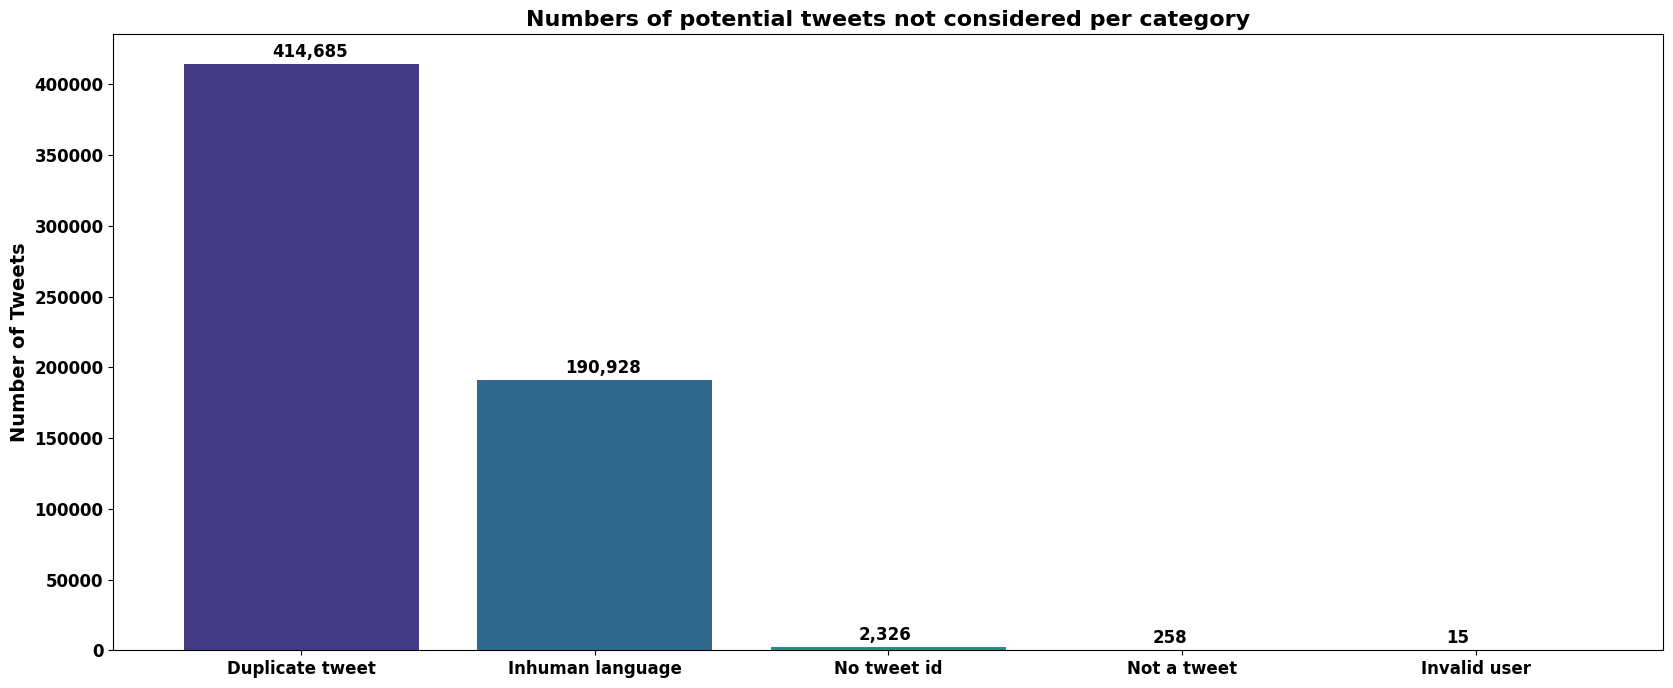

In [9]:
data = [258, 414685, 190928, 2326, 15] # was done with another script
labels = ['Not a tweet', 'Duplicate tweet', 'Inhuman language',
          'No tweet id', "Invalid user"]

# Ensure data and labels have the same length
assert len(data) == len(labels), "Data and labels must be the same length."

# Sort the data and labels in decreasing order
sorted_data_labels = sorted(zip(data, labels), reverse=True)
data, labels = zip(*sorted_data_labels)

# Choose a color palette

# Create the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(labels, data, color=sns.color_palette("viridis", len(labels)))

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 5000, f'{yval:,}',
             fontsize=12, weight='bold')

# Customize the chart
plt.title('Numbers of potential tweets not considered per category',
          fontsize=16, weight='bold')
plt.ylabel('Number of Tweets', fontsize=14, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold');

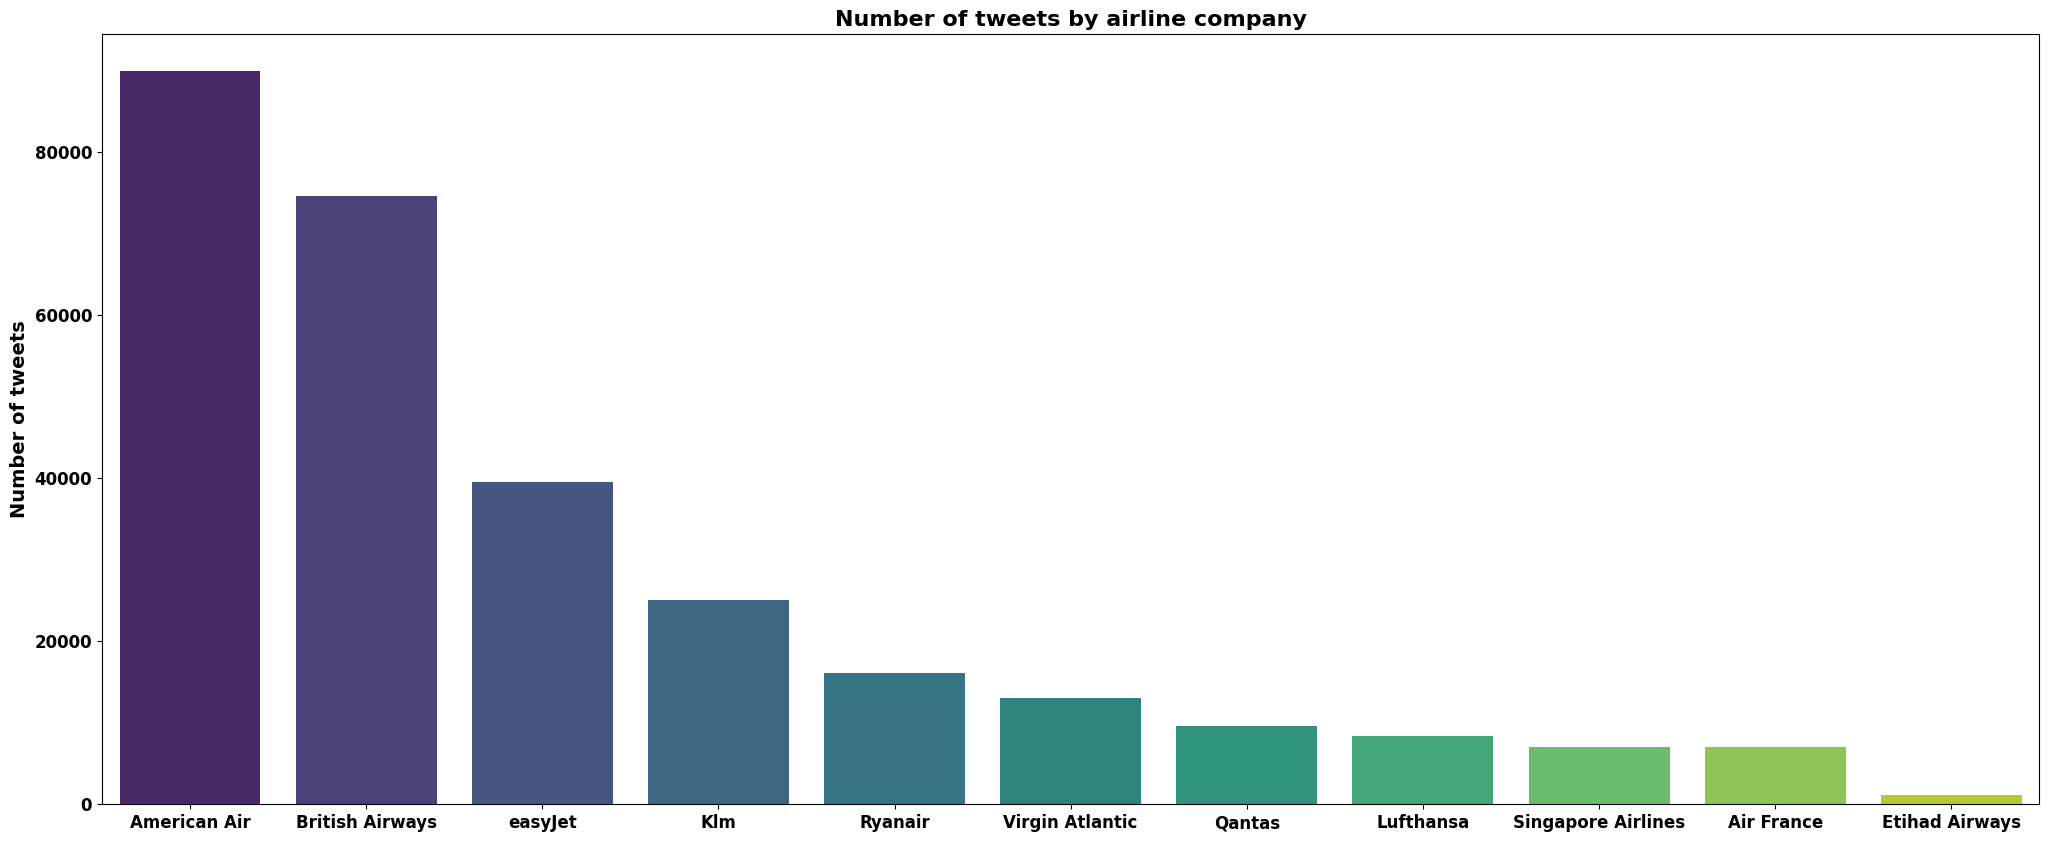

In [10]:
avia_names = set(COMPANY_NAME_TO_ID.values())

replies_to_avia_companies_df = test_data.loc[test_data['user_id'].apply(
    lambda x: any(x == avia_name for avia_name in avia_names)
    )]
replies_to_avia_companies_df = replies_to_avia_companies_df.reset_index()\
    .groupby("user_id").count()[['tweet_id']]\
        .sort_values('tweet_id', ascending=False).reset_index()
replies_to_avia_companies_df["user_id"] = replies_to_avia_companies_df["user_id"]\
    .apply(lambda user_id: COMPANY_ID_TO_NAME.get(user_id, user_id))
replies_to_avia_companies_df = replies_to_avia_companies_df.set_index("user_id")
replies_to_avia_companies_df

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
sns.barplot(data=replies_to_avia_companies_df, ax=ax, x='user_id', y='tweet_id',
            palette=sns.color_palette("viridis", replies_to_avia_companies_df.index.nunique()),
            hue='user_id', dodge=False)
# Customize the chart
plt.title('Number of tweets by airline company', fontsize=16, weight='bold')
plt.ylabel('Number of tweets', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold');

In [11]:
df_airlines_popularity = test_data[test_data['user_id']\
    .apply(lambda x: any(x == avia_name for avia_name in avia_names))]\
        .groupby("user_id")\
            .agg(
                retweet_count=("retweet_count", "sum"),
                favorite_count=("favorite_count", "sum"),
                reply_count=("reply_count", "sum"),
                quote_count=("quote_count", "sum"),
            )
df_airlines_popularity.index = df_airlines_popularity.index.map(
    lambda user_id: COMPANY_ID_TO_NAME[user_id]
    )
df_airlines_popularity.index.name = "Airlines"
df_airlines_popularity

retweet_count  favorite_count  reply_count  quote_count
Airlines                                                                   
Air France                     14             100           14            2
Lufthansa                     419            4690          300          442
Ryanair                       392            1829          140          133
British Airways               496            1577         1845          244
Virgin Atlantic               196            1489           97           46
Qantas                       5019           15682          901         1339
American Air                  513            3971          552          165
Singapore Airlines            121             506           50           22
easyJet                        19              77           16            3
Etihad Airways                541            3682           96           50
Klm                           749            4026          235          106

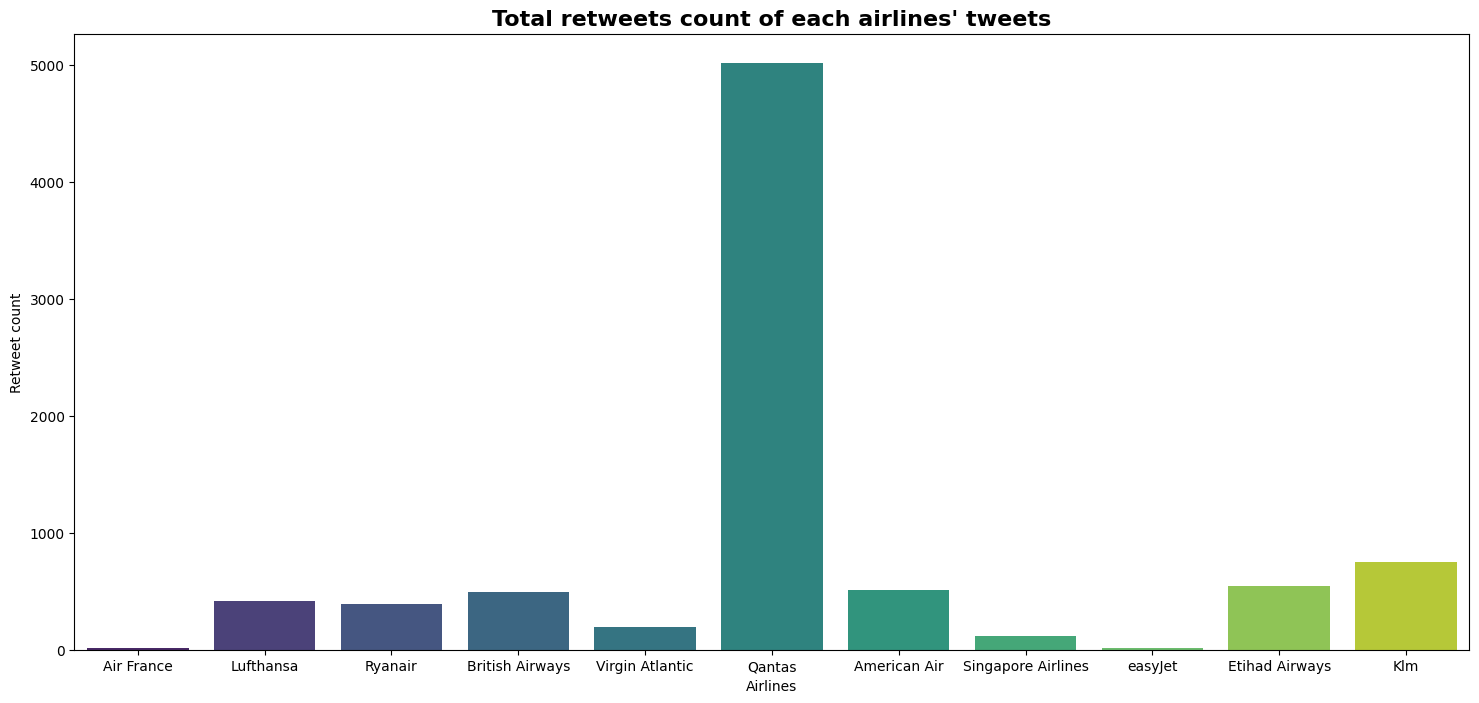

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="retweet_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total retweets count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Retweet count");

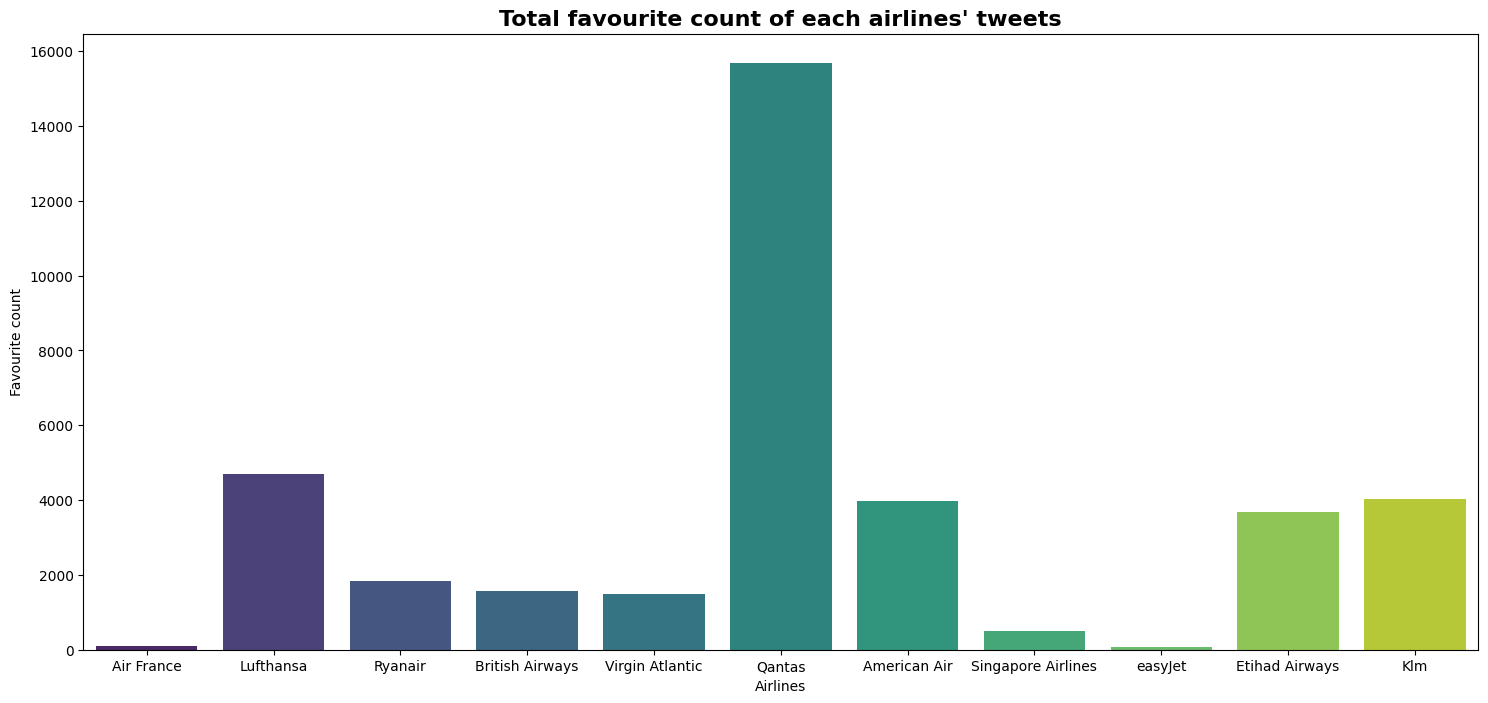

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="favorite_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total favourite count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Favourite count");

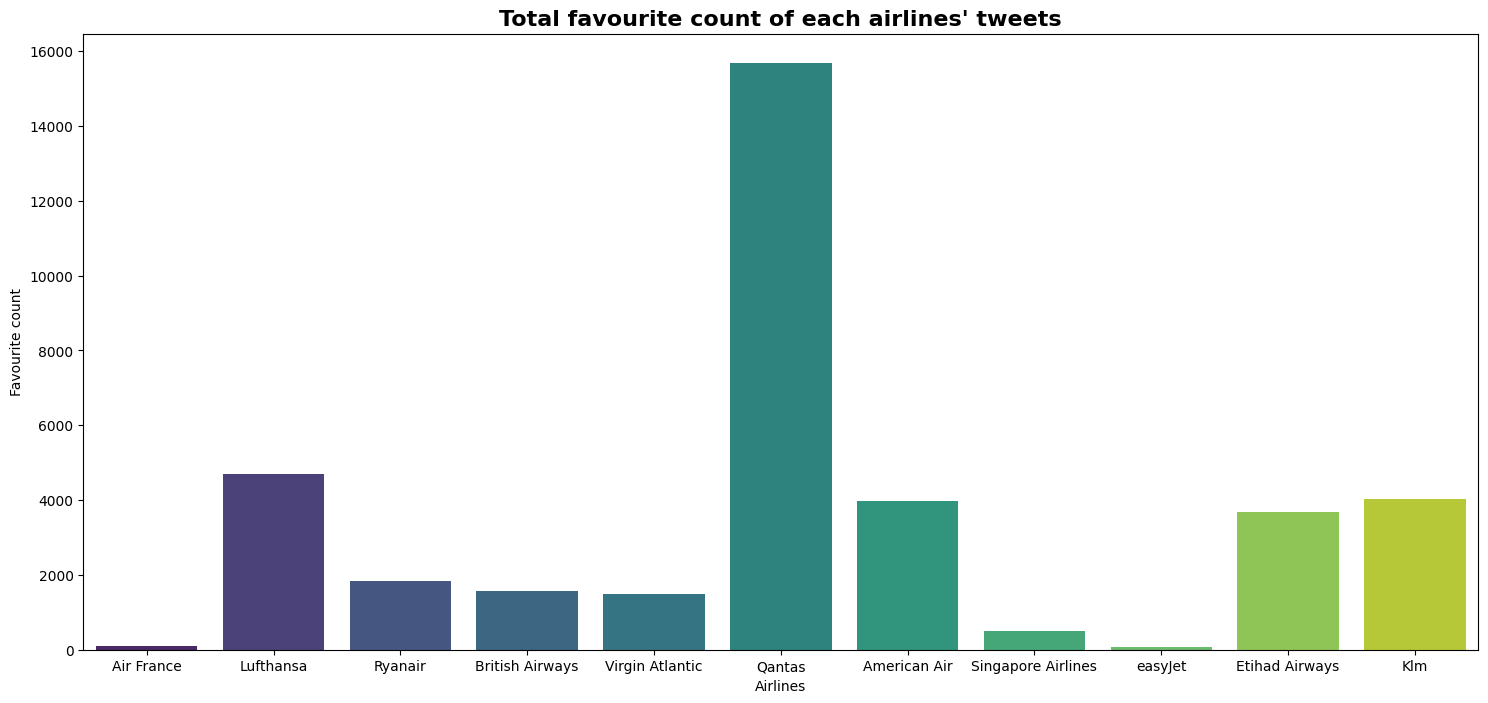

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="favorite_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total favourite count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Favourite count");

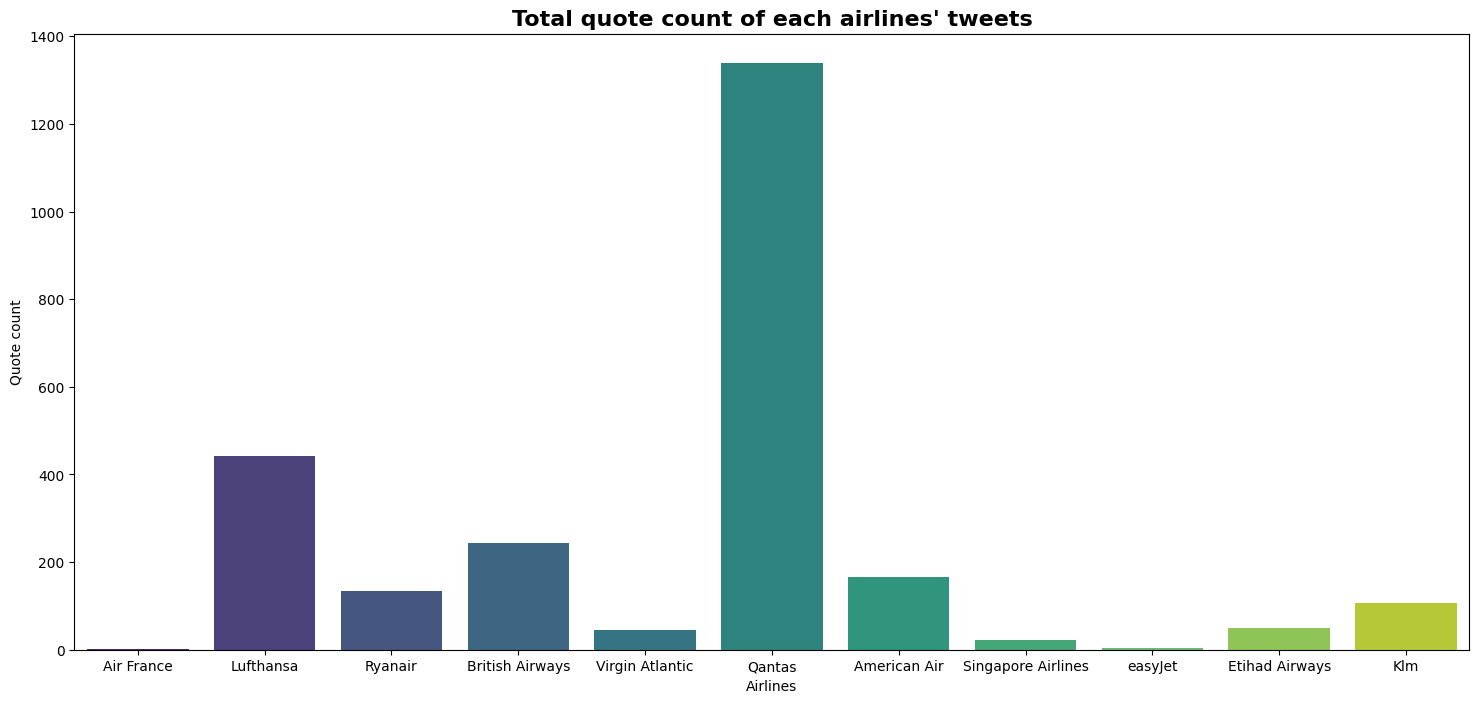

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="quote_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total quote count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Quote count");

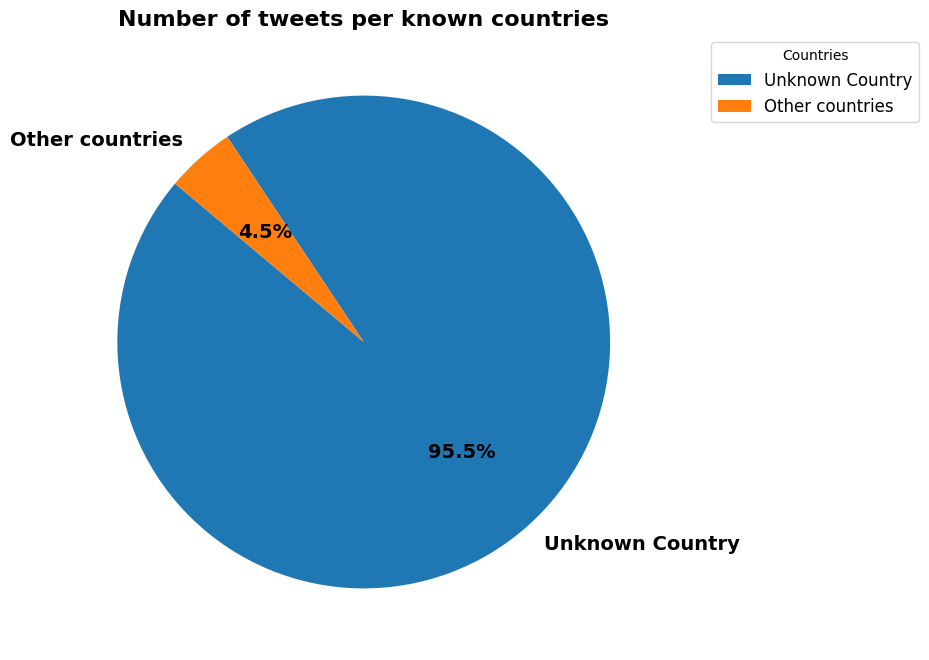

In [16]:
df_country_dist = test_data.groupby('country_code', observed=True)\
    [["user_id"]].count().sort_values('user_id', ascending=False)\
        .rename(columns={"user_id":"Tweets number"})
df_country_dist.index = df_country_dist.index.map(get_country_name)
df_top_country = df_country_dist.nlargest(1, 'Tweets number')
df_other_country = df_country_dist.loc[~df_country_dist.index.isin(df_top_country.index)]
df_country_agg = df_other_country.sum()

df_country_agg.name = 'Other countries'
df_country_agg_final = pd.concat([df_top_country, df_country_agg.to_frame().T])
df_country_agg_final.index.name = 'Country'
plt.figure(figsize=(10, 8))
plt.pie(df_country_agg_final['Tweets number'], labels=df_country_agg_final.index,
        autopct='%1.1f%%', startangle=140,
        textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Number of tweets per known countries", fontsize=16, weight='bold')
plt.legend(df_country_agg_final.index, title="Countries",
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

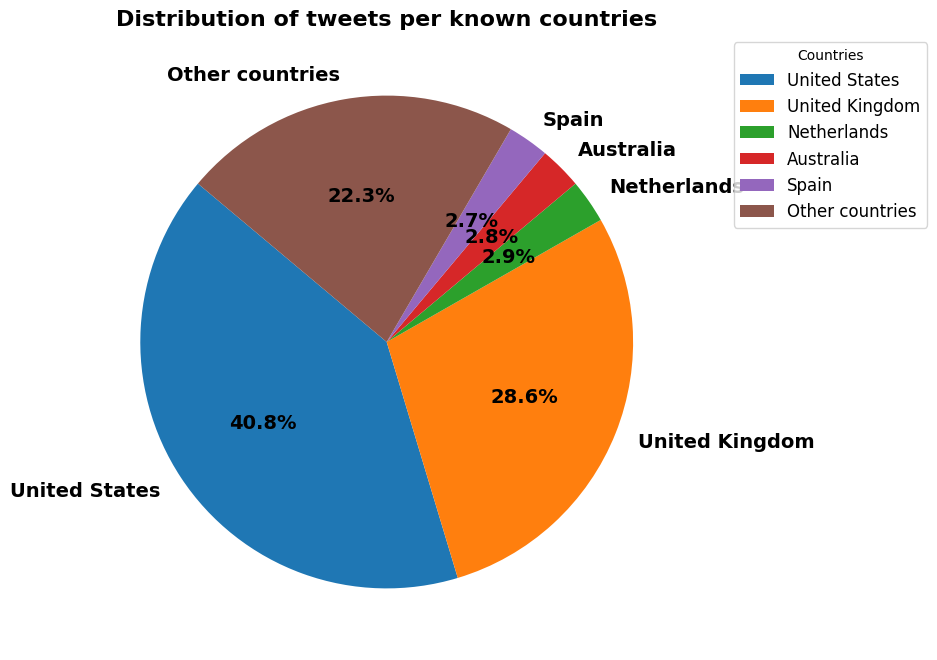

In [17]:
df_country_known = df_country_dist[df_country_dist.index != "Unknown Country"].copy()

top_10_countries = df_country_known.nlargest(5, 'Tweets number')

other_countries_df = df_country_known.loc[~df_country_known.index.isin(top_10_countries.index)]

other_countries_agg = other_countries_df.sum()
other_countries_agg.name = 'Other countries'


df_top_country_known = df_country_known.nlargest(5, 'Tweets number')
df_other_country_known = df_country_known.loc[~df_country_known.index.isin(df_top_country_known.index)]
df_country_known_agg = df_other_country_known.sum()

df_country_known_agg.name = 'Other countries'
df_country_known_agg_final = pd.concat([df_top_country_known, df_country_known_agg.to_frame().T])
df_country_known_agg_final.index.name = 'Country'
plt.figure(figsize=(10, 8))
plt.pie(df_country_known_agg_final["Tweets number"], labels=df_country_known_agg_final.index,
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14, 'weight': 'bold'}, )
plt.title("Distribution of tweets per known countries", fontsize=16, weight='bold')
plt.legend(df_country_known_agg_final.index, title="Countries",
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

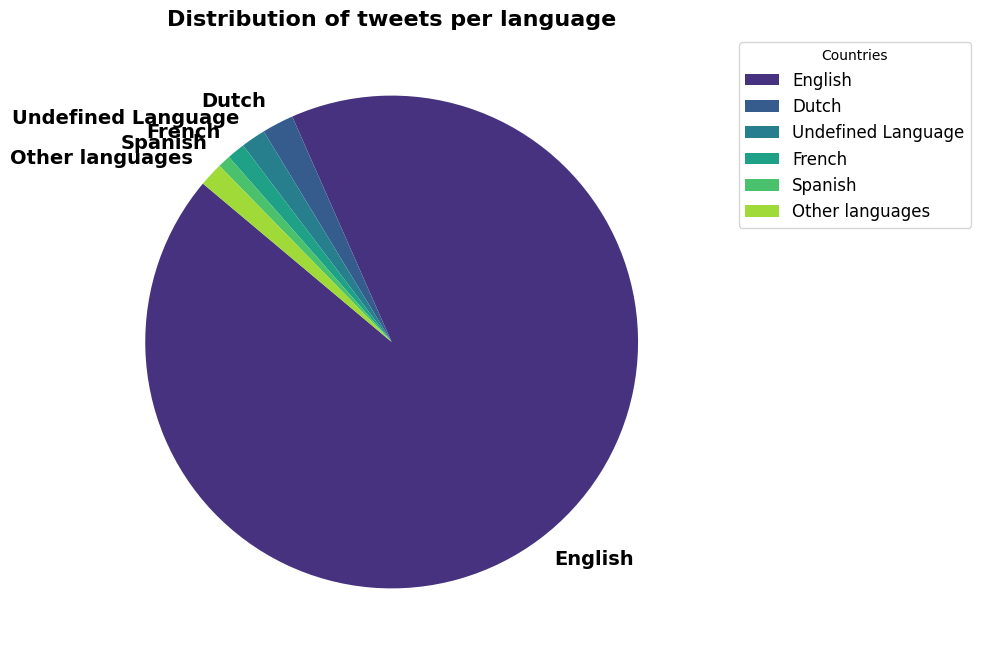

In [18]:
df_lang_distr = test_data.groupby('lang', observed=True)\
    [["user_id"]].count().sort_values('user_id', ascending=False)\
        .rename(columns={"user_id":"Tweets number"})
df_top_lang = df_lang_distr.nlargest(5, 'Tweets number')

df_other_lang = df_lang_distr.loc[~df_lang_distr.index.isin(df_top_lang.index)]

df_lang_agg = df_other_lang.sum()
df_lang_agg.name = 'Other languages'

df_lang_agg_final = pd.concat([df_top_lang, df_lang_agg.to_frame().T])
df_lang_agg_final.index.name = 'Language'
df_lang_agg_final.index = df_lang_agg_final.index.map(get_full_language_name)
plt.figure(figsize=(10, 8))
plt.pie(df_lang_agg_final["Tweets number"], labels=df_lang_agg_final.index,
        startangle=140, textprops={'fontsize': 14, 'weight': 'bold'},
        colors=sns.color_palette("viridis", len(df_lang_agg_final)))
plt.title('Distribution of tweets per language', fontsize=16, weight='bold')
plt.legend(df_lang_agg_final.index, title="Countries",
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [19]:
df_reply["tweet_creation_time"] = pd.to_datetime(df_reply["tweet_creation_time"])
df_reply["original_tweet_creation_time"] = pd.to_datetime(df_reply["original_tweet_creation_time"])
df_reply["response_time"] = df_reply["tweet_creation_time"] - df_reply["original_tweet_creation_time"]
df_reply["airline"] = df_reply["user_id"].map(COMPANY_ID_TO_NAME)
df_reply["original_airline"] = df_reply["original_user_id"].map(COMPANY_ID_TO_NAME)
# Convert datetime and timedelta columns
df_reply['response_time'] = pd.to_timedelta(df_reply['response_time'])

# Calculate average response time per airline
average_response_time_airline = df_reply[df_reply['airline'].notnull()]\
    .groupby('airline')['response_time'].mean()

# Calculate average response time for others users to react to each airline
average_response_time_reactions = df_reply[df_reply['original_airline'].notnull()]\
    .groupby('original_airline')['response_time'].mean()

# Combine the results into one DataFrame for plotting
df_airline_response = pd.DataFrame({
    'Airline Response Time': average_response_time_airline.reindex(
        average_response_time_airline.index.union(average_response_time_reactions.index)
        ),
    'User Reaction Time': average_response_time_reactions.reindex(
        average_response_time_airline.index.union(average_response_time_reactions.index)
        )
})
df_airline_response.index.name = "Airline"
df_airline_response_plot = df_airline_response.dropna().copy()
df_airline_response_plot['Airline Response Time, hours'] = df_airline_response_plot['Airline Response Time'].dt.total_seconds() / 3600
df_airline_response_plot['User Reaction Time, days'] = df_airline_response_plot['User Reaction Time'].dt.total_seconds() / 86.400

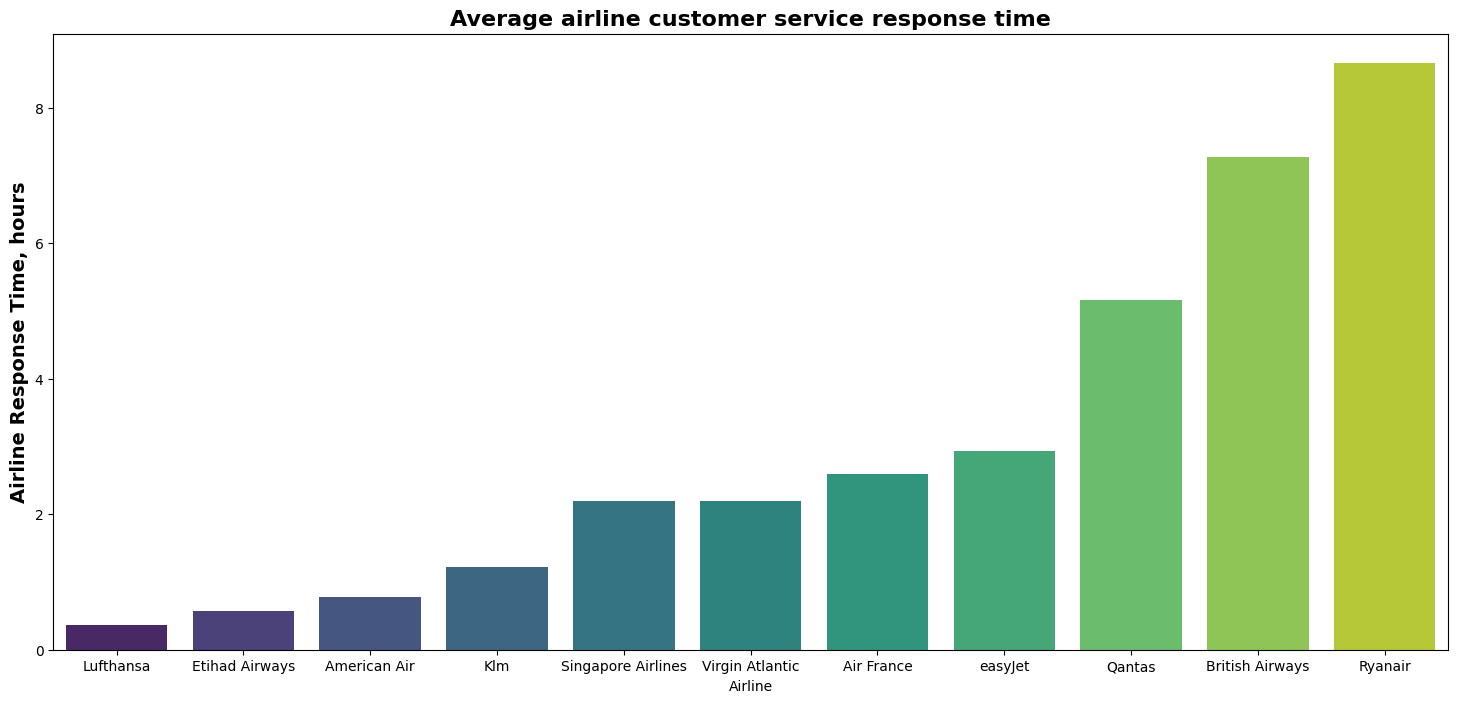

In [20]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airline_response_plot.sort_values('Airline Response Time, hours'),
            x='Airline', y='Airline Response Time, hours', ax=ax,
            palette=sns.color_palette("viridis", df_airline_response_plot.index.nunique()),
            hue='Airline', dodge=False)
ax.set_title('Average airline customer service response time',
             fontsize=16, weight='bold')
ax.set_ylabel('Airline Response Time, hours', fontsize=14, weight='bold');

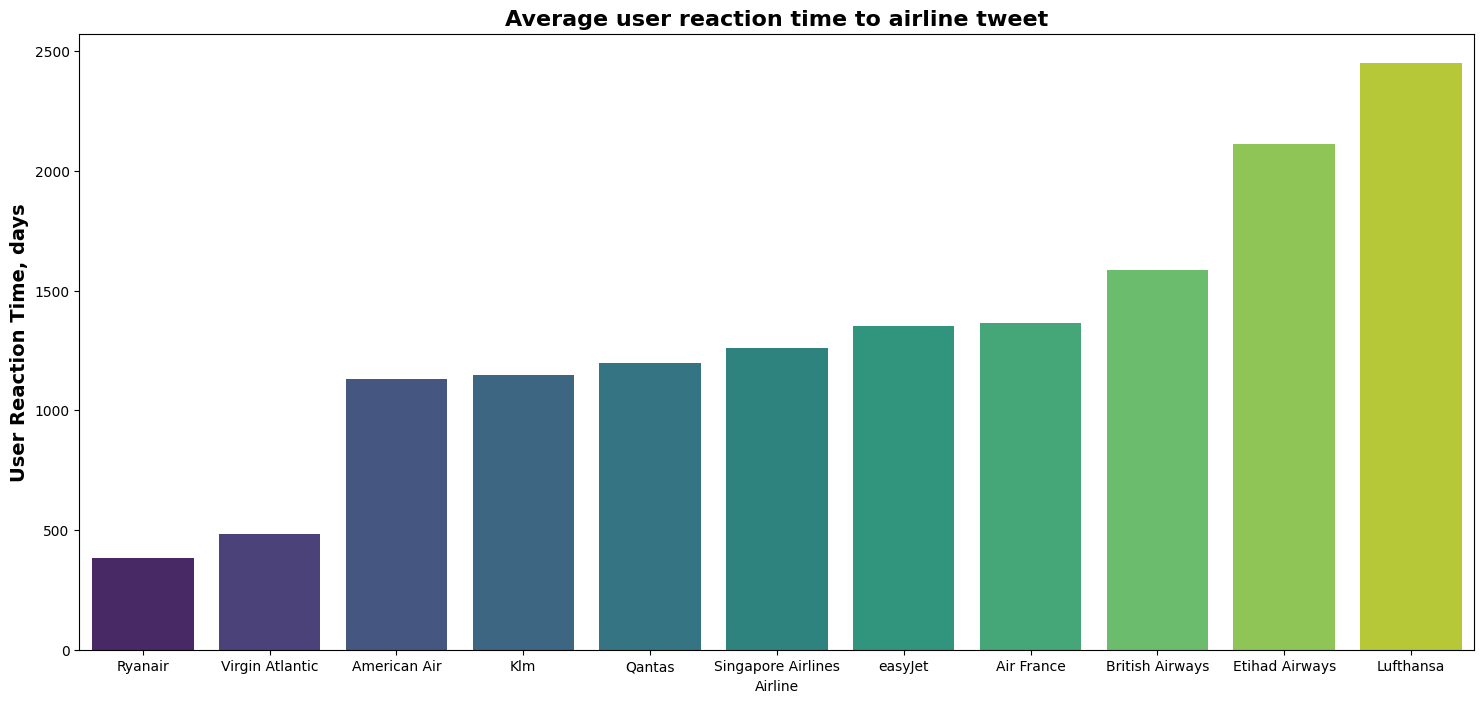

In [21]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airline_response_plot.sort_values('User Reaction Time, days'),
            x='Airline', y='User Reaction Time, days', ax=ax,
            palette=sns.color_palette("viridis", df_airline_response_plot.index.nunique()),
            hue='Airline', dodge=False)
ax.set_title('Average user reaction time to airline tweet', fontsize=16, weight='bold')
ax.set_ylabel('User Reaction Time, days', fontsize=14, weight='bold');

# Sprint 2

In [22]:
df_tweets_and_users = test_data.copy()

In [23]:
QUERY_CONVERSATIONS = f"""
SELECT c.*
FROM Conversations c
JOIN Tweets t ON c.tweet_id = t.tweet_id
WHERE t.creation_time BETWEEN '{start_date_sql}' AND '{end_date_sql}'
AND NOT EXISTS (
    SELECT 1
    FROM Tweets t2
    JOIN Conversations c2 ON t2.tweet_id = c2.tweet_id
    WHERE c2.conversation_id = c.conversation_id
    AND t2.creation_time NOT BETWEEN '{start_date_sql}' AND '{end_date_sql}'
)
"""

df_conversations = get_dataframe_from_query(QUERY_CONVERSATIONS, connection_params, local, DTYPES_CONVERSATIONS, index_col=["conversation_id", "tweet_order"])

In [24]:
df_conversations_category = get_dataframe_from_query(QUERY_CONVERSATIONS_CATEGORY, connection_params, local, DTYPES_CONVERSATIONS_CATEGORY, "conversation_id")
df_conversations_category

category
conversation_id                                         
1                Customer Service and Special Assistance
2                                   In-Flight Experience
3                            Flight Information Requests
4                                   In-Flight Experience
5                               Delays and Cancellations
...                                                  ...
458720                          Refunds and Transactions
458721                               Baggage and Luggage
458722           Customer Service and Special Assistance
458723                       Flight Information Requests
458724                              In-Flight Experience

[458724 rows x 1 columns]

In [25]:
df_all = pd.merge(df_conversations, df_tweets_and_users, left_on='tweet_id', right_index=True, how='inner')

In [26]:
df_reset = df_all.reset_index()
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)

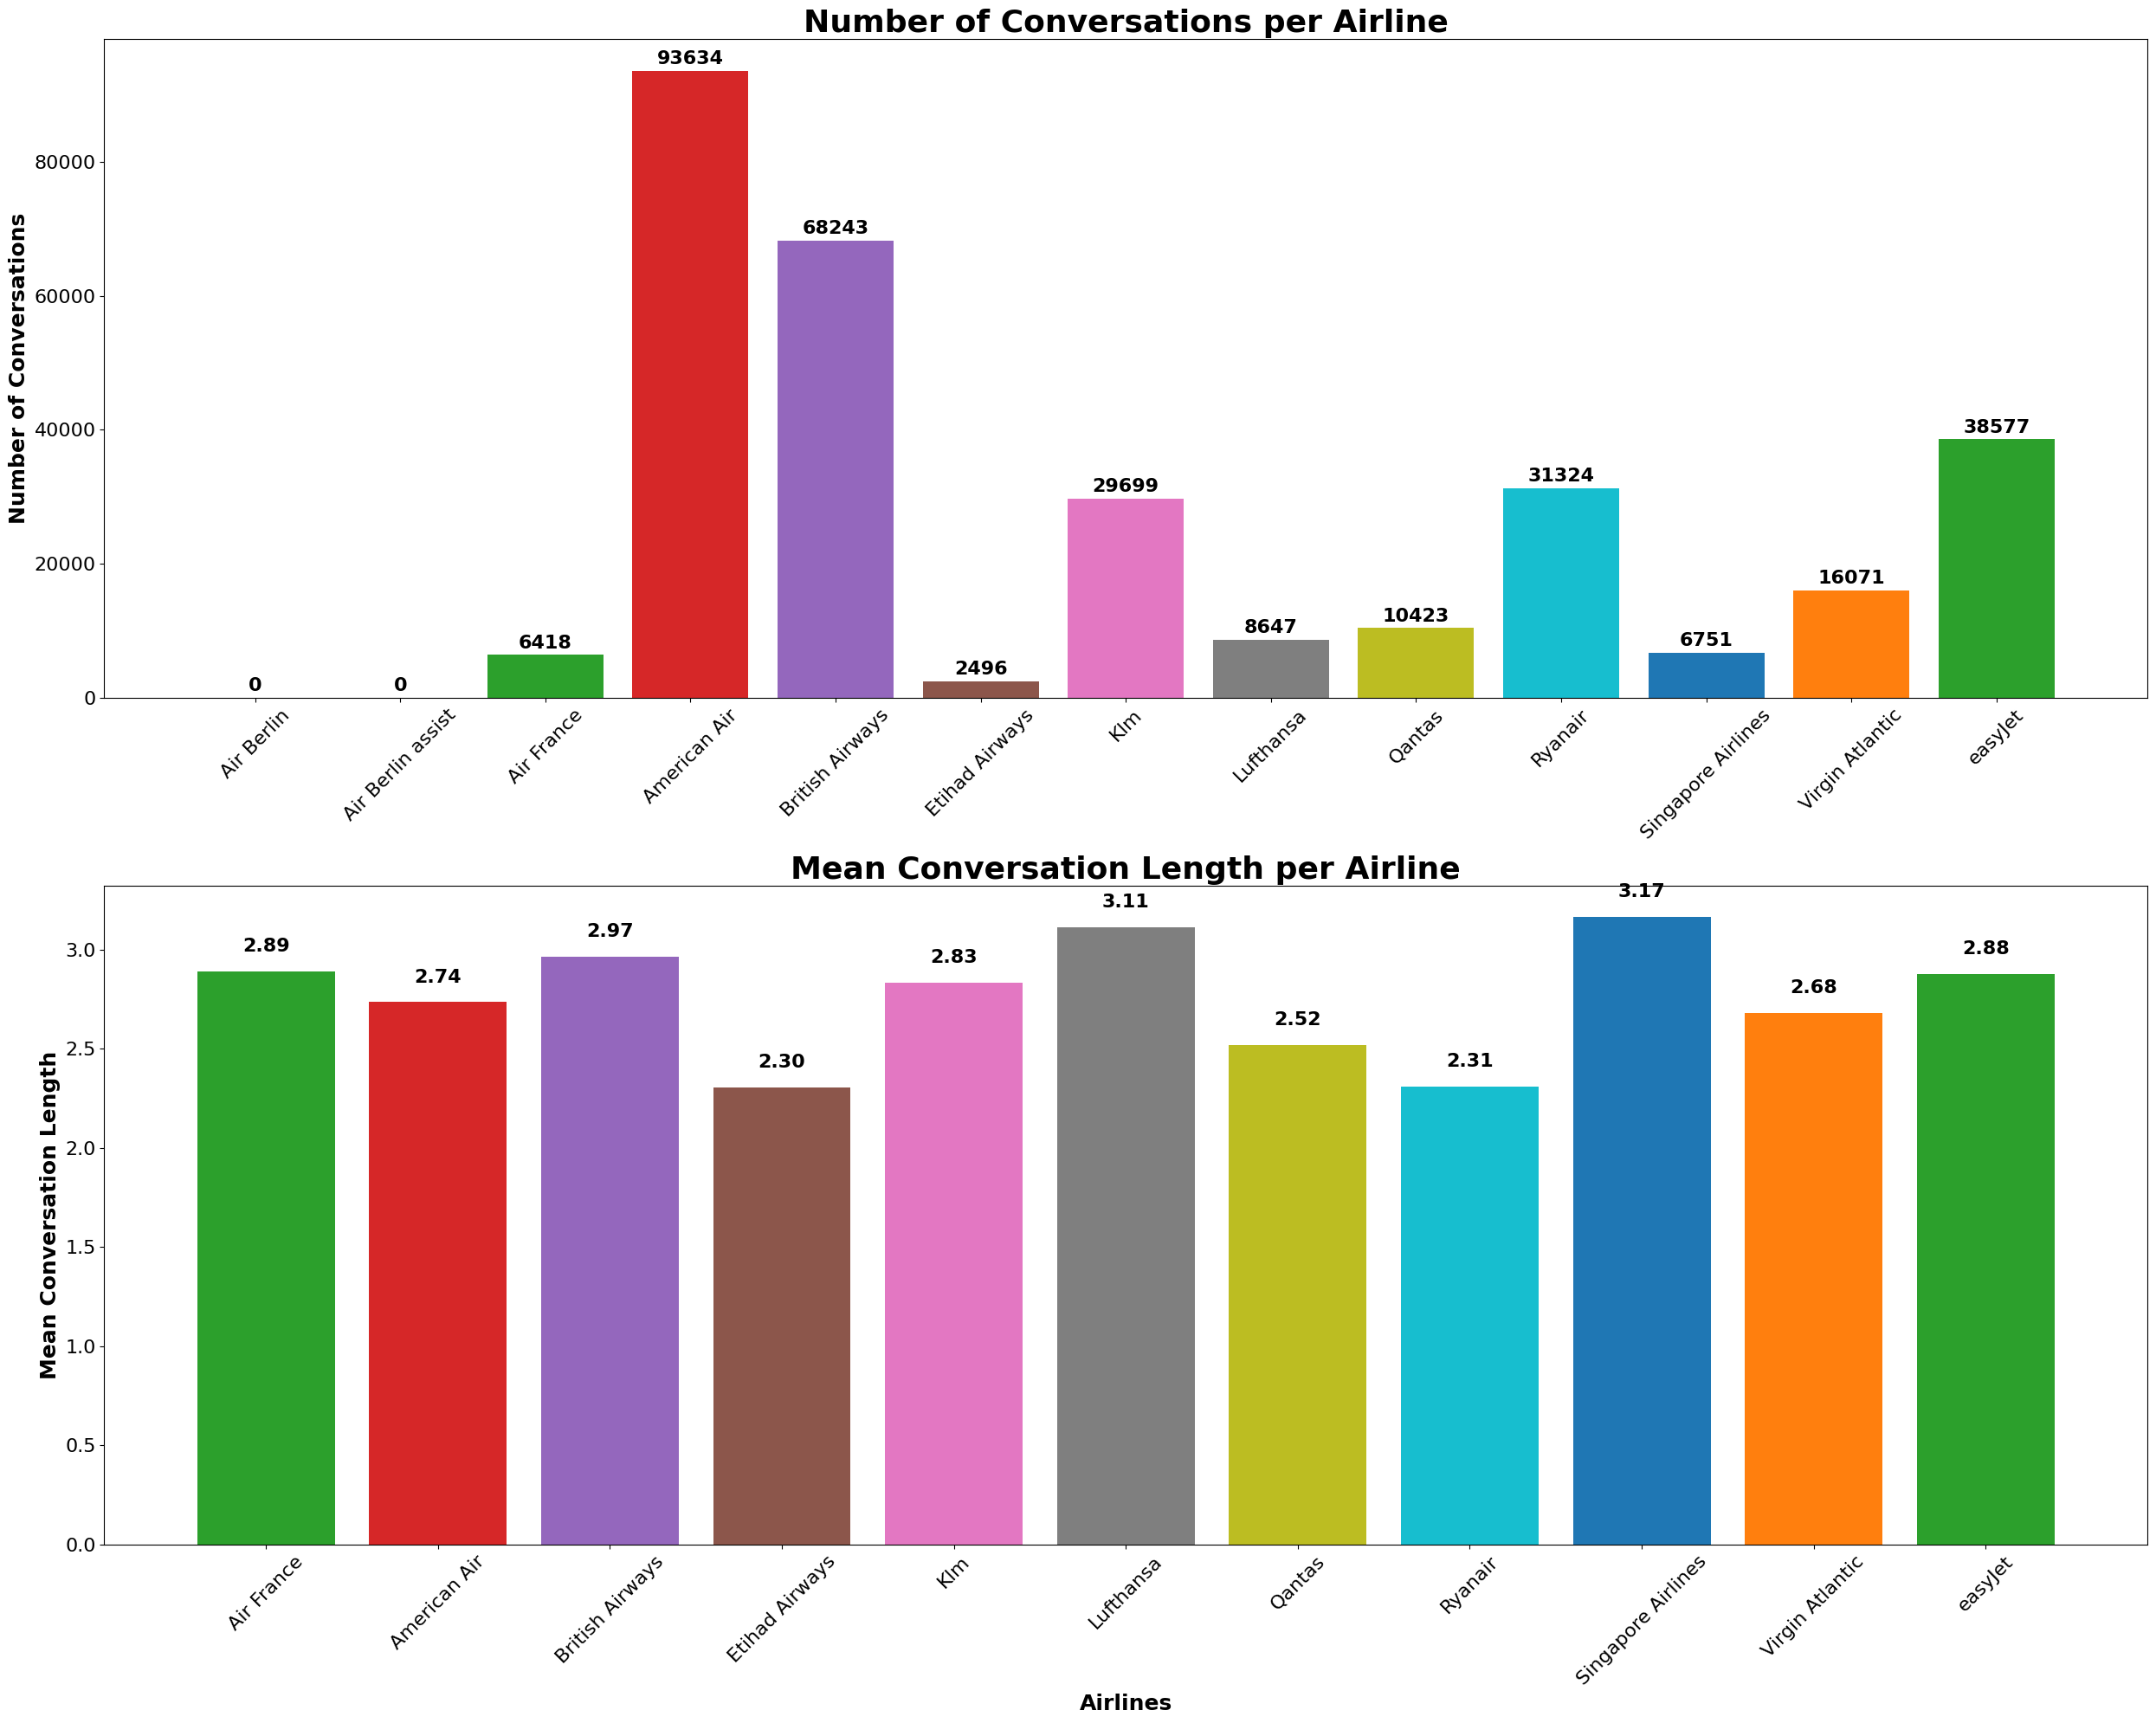

In [27]:
# Calculate the number of conversations per user and create a mapping to user names
user_conversations_count = {
    COMPANY_ID_TO_NAME[user_id]: df_reset[df_reset['user_id'] == user_id]['conversation_id'].nunique()
    for user_id in COMPANY_ID_TO_NAME.keys()
}

# Use a predefined color scheme
colors = list(mcolors.TABLEAU_COLORS.values())

# Sort the dictionary by airline names alphabetically
sorted_user_conversations_count = dict(sorted(user_conversations_count.items()))

# Calculate the mean conversation length per airline
conversation_lengths = df_reset.groupby('conversation_id').size().reset_index(name='conversation_length')
df_airline_count = df_reset.dropna(subset=['airline']).groupby('conversation_id')['airline'].first().reset_index()
mean_conversation_length = pd.merge(df_airline_count, conversation_lengths, on='conversation_id').groupby('airline').mean()['conversation_length']

# Ensure all values are finite
mean_conversation_length = mean_conversation_length[np.isfinite(mean_conversation_length)]
sorted_mean_conversation_length = mean_conversation_length.reindex(sorted_user_conversations_count.keys())

# Plot the number of conversations per airline
plt.figure(figsize=(25, 20))
plt.subplot(2, 1, 1)
bars1 = plt.bar(sorted_user_conversations_count.keys(), sorted_user_conversations_count.values(), color=colors[:len(sorted_user_conversations_count)])
plt.ylabel('Number of Conversations', fontsize=18, fontweight='bold')
plt.title('Number of Conversations per Airline', fontsize=26, fontweight='bold')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add data labels on top of each bar
for bar in bars1:
    yval = bar.get_height()
    if np.isfinite(yval):
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=16, fontweight='bold')

# Plot the mean conversation length per airline
plt.subplot(2, 1, 2)
bars2 = plt.bar(sorted_mean_conversation_length.index, sorted_mean_conversation_length.values, color=colors[:len(sorted_mean_conversation_length)])
plt.xlabel('Airlines', fontsize=18, fontweight='bold')
plt.ylabel('Mean Conversation Length', fontsize=18, fontweight='bold')
plt.title('Mean Conversation Length per Airline', fontsize=26, fontweight='bold')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add data labels on top of each bar
for bar in bars2:
    yval = bar.get_height()
    if np.isfinite(yval):
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f'{yval:.2f}', ha='center', fontsize=16, fontweight='bold')

plt.tight_layout()

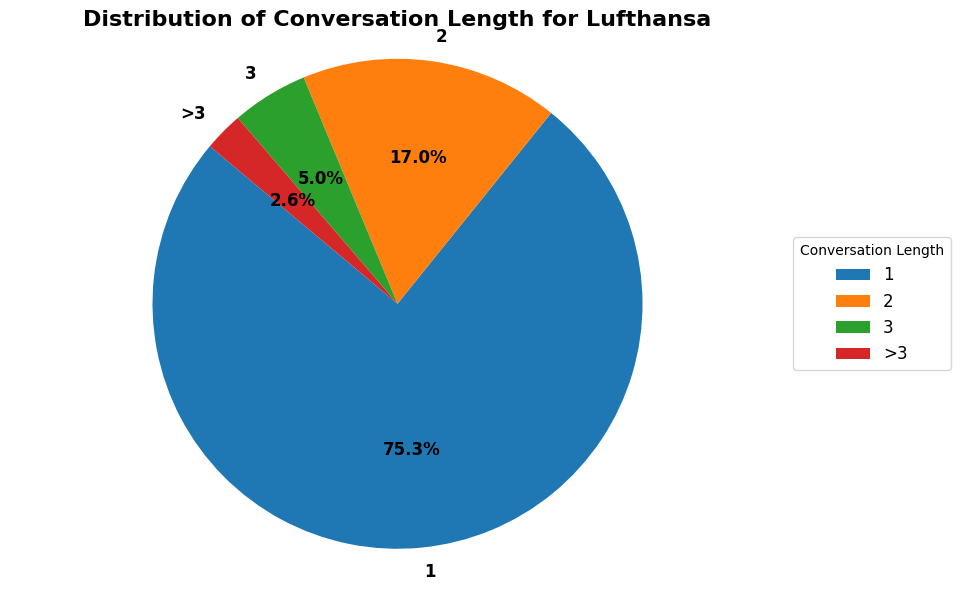

In [28]:
# Define a function to process the data
def process_conversation_data(df, user_id=None, bins=None, labels=None):
    if user_id:
        df = df[df['user_id'] == user_id]

    conversation_lengths = df.groupby('conversation_id').size().reset_index(name='conversation_length')

    if bins and labels:
        conversation_lengths['length_bin'] = pd.cut(conversation_lengths['conversation_length'], bins=bins, labels=labels, right=False)
        return conversation_lengths['length_bin'].value_counts().sort_index()
    else:
        conversation_lengths['conversation_length'] = conversation_lengths['conversation_length'].apply(lambda x: str(x) if x <= 5 else '>5')
        return conversation_lengths['conversation_length'].value_counts().sort_index()

# Define a function to plot the data
def plot_pie_chart(distribution, title, legend_title):
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    plt.figure(figsize=(10, 7))
    patches, texts, autotexts = plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140, colors=colors[:len(distribution)])
    
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
    
    plt.legend(patches, distribution.index, title=legend_title, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Process and plot the data for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
bins = [1, 2, 3, 4, float('inf')]
labels = ['1', '2', '3', '>3']
lufthansa_conversation_lengths_dist = process_conversation_data(df_reset, user_id=lufthansa_user_id, bins=bins, labels=labels)
plot_pie_chart(lufthansa_conversation_lengths_dist, 'Distribution of Conversation Length for Lufthansa', 'Conversation Length')

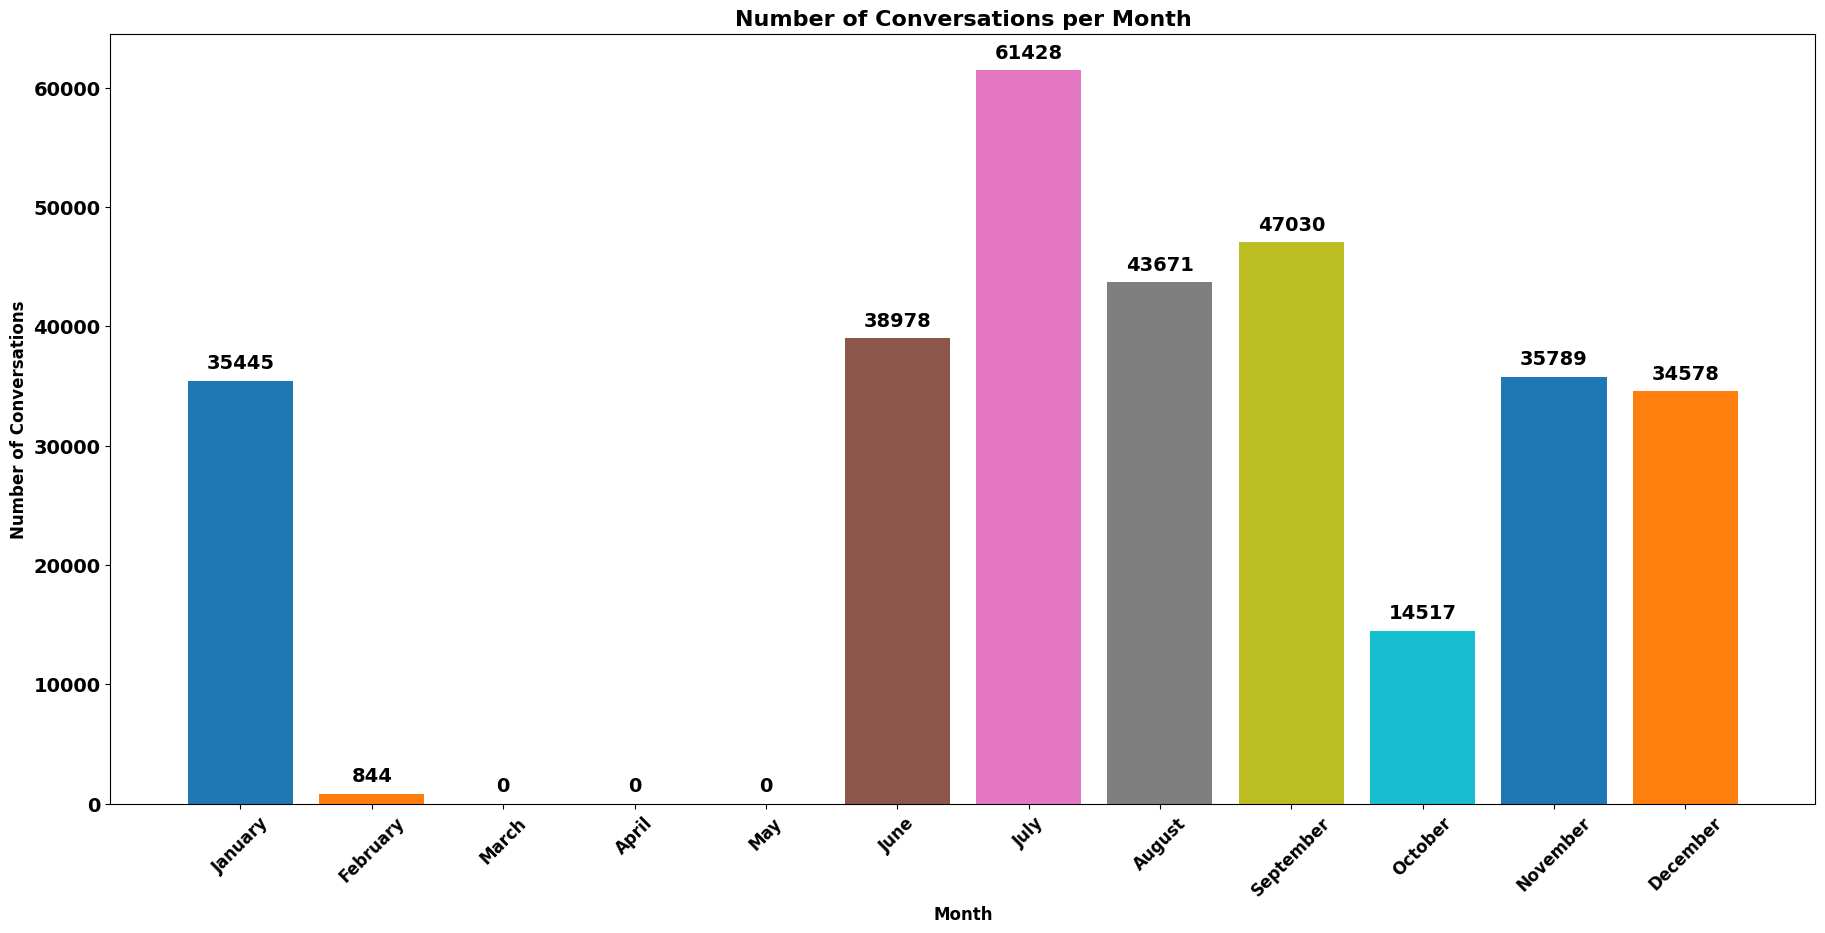

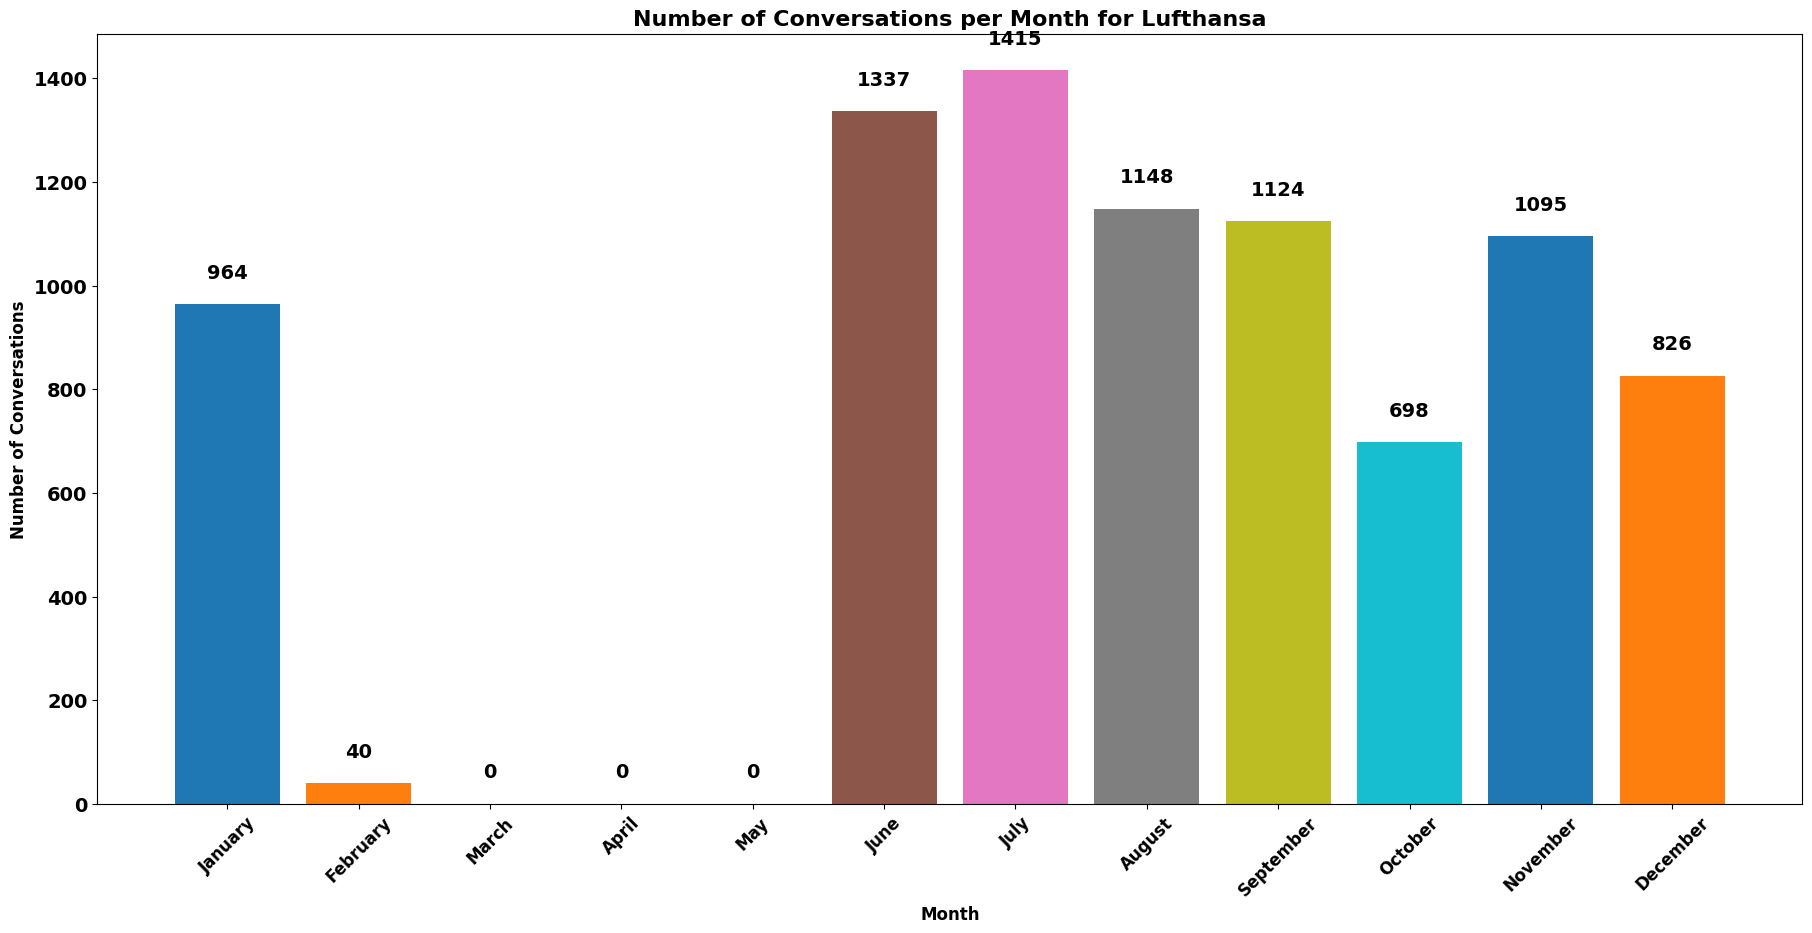

In [29]:
# Define a function to process the data
def process_conversations_per_month(df, user_id=None):
    if user_id:
        df = df[df['user_id'] == user_id].copy()

    df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])

    # Extract the first tweet's creation time for each conversation
    first_tweet_times = df.groupby('conversation_id')['tweet_creation_time'].min()

    # Extract the month name from the tweet creation time
    first_tweet_times_month = first_tweet_times.dt.month_name()

    return first_tweet_times_month.value_counts().reindex(
        [
            'January',
            'February',
            'March',
            'April',
            'May',
            'June',
            'July',
            'August',
            'September',
            'October',
            'November',
            'December',
        ],
        fill_value=0,
    )

# Define a function to plot the bar chart
def plot_bar_chart(conversations_per_month, title, xlabel, ylabel, bar_label_offset=1000):
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    plt.figure(figsize=(22, 10))
    bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + bar_label_offset, int(yval), ha='center', fontsize=14, fontweight='bold')

    plt.show()

# Process and plot the data for the general case
conversations_per_month = process_conversations_per_month(df_reset)
plot_bar_chart(conversations_per_month, 'Number of Conversations per Month', 'Month', 'Number of Conversations')

# Process and plot the data for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
conversations_per_month_lufthansa = process_conversations_per_month(df_reset, user_id=lufthansa_user_id)
plot_bar_chart(conversations_per_month_lufthansa, "Number of Conversations per Month for Lufthansa", 'Month', 'Number of Conversations', bar_label_offset=50)

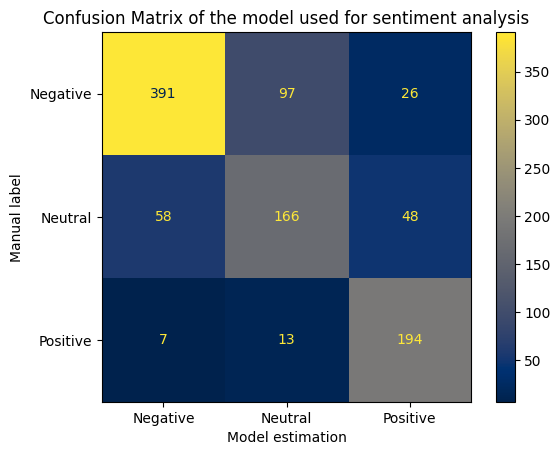

In [30]:
# Extract true sentiment and predicted sentiment



df_test = pd.read_csv("sentiment_accuracy.csv")
y_true = df_test['airline_sentiment']
y_pred = df_test['roberta_xlm']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])

# Plot the confusion matrix
disp.plot(cmap='cividis')
plt.ylabel('Manual label')
plt.xlabel('Model estimation')
plt.title('Confusion Matrix of the model used for sentiment analysis');

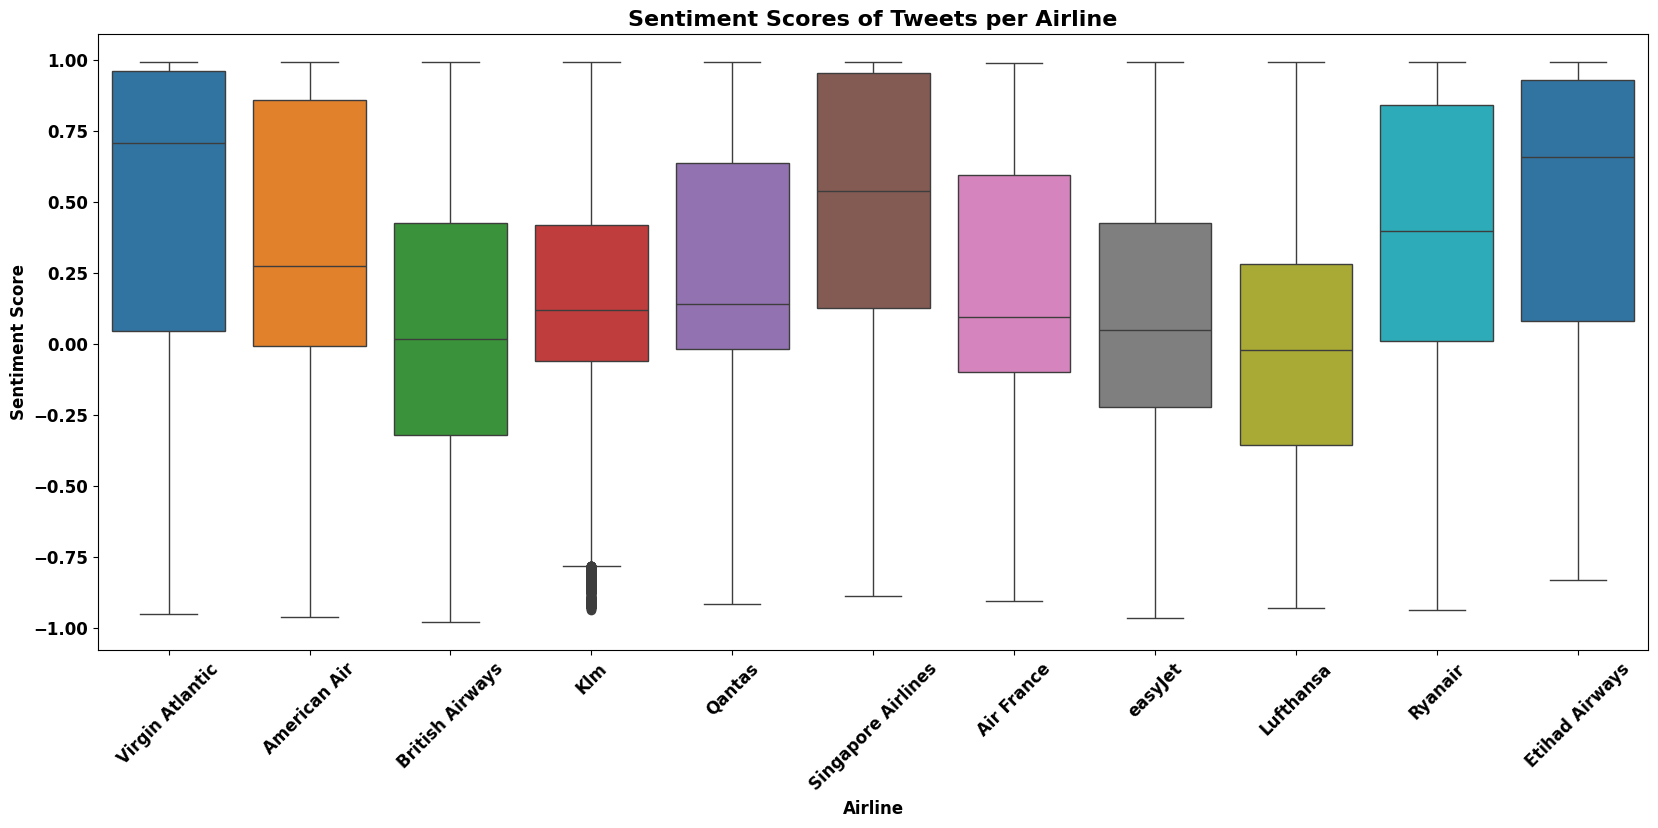

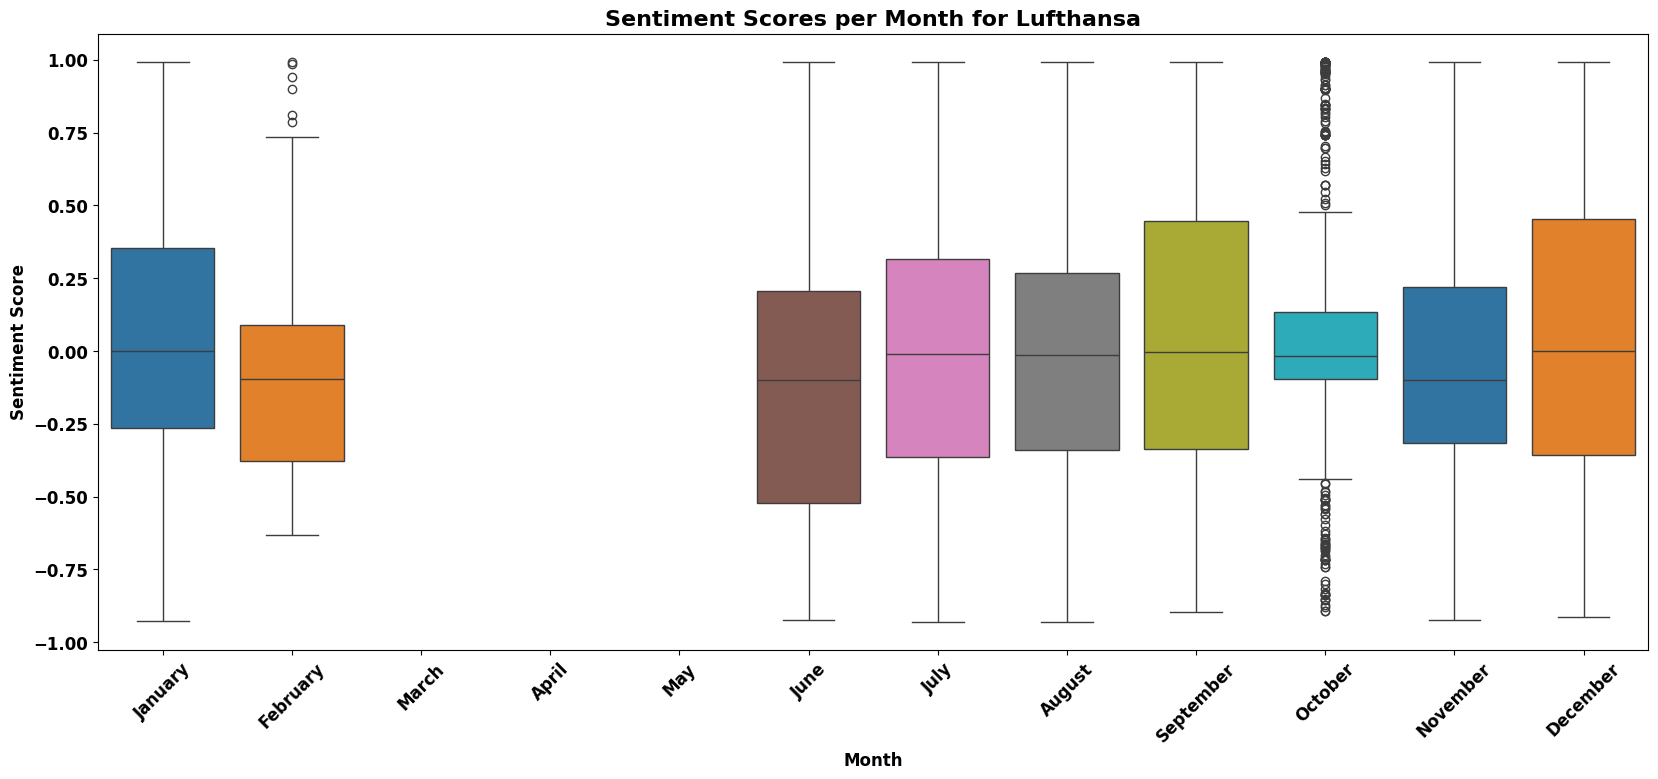

In [31]:
# Define a function to process sentiment scores and map user IDs to airline names
def process_airline_sentiment_scores(df, user_id=None, group_by='airline'):
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    
    if group_by == 'airline':
        df['airline'] = df['user_id'].map(COMPANY_ID_TO_NAME)
        if user_id:
            df = df[df['user_id'] == user_id].copy()
        df = df[df['airline'].notnull()]
    elif group_by == 'month':
        if user_id:
            df = df[df['user_id'] == user_id].copy()
        df['month'] = df['tweet_creation_time'].dt.strftime('%B')
    
    return df

# Define a function to plot the box plot
def plot_box_plot(data, x, y, title, xlabel, ylabel, order=None, palette=None):
    plt.figure(figsize=(20, 8))
    sns.boxplot(x=x, y=y, data=data, order=order, palette=palette)
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.show()

# Define colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Process and plot the data for sentiment scores per airline
airline_tweets = process_airline_sentiment_scores(df_reset)
palette = {airline: colors[i % len(colors)] for i, airline in enumerate(airline_tweets['airline'].unique())}
plot_box_plot(airline_tweets, 'airline', 'sentiment_score', 'Sentiment Scores of Tweets per Airline', 'Airline', 'Sentiment Score', palette=palette)

# Process and plot the data for sentiment scores per month for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_tweets = process_airline_sentiment_scores(df_reset, user_id=lufthansa_user_id, group_by='month')
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
plot_box_plot(lufthansa_tweets, 'month', 'sentiment_score', 'Sentiment Scores per Month for Lufthansa', 'Month', 'Sentiment Score', order=month_order, palette=colors[:12])

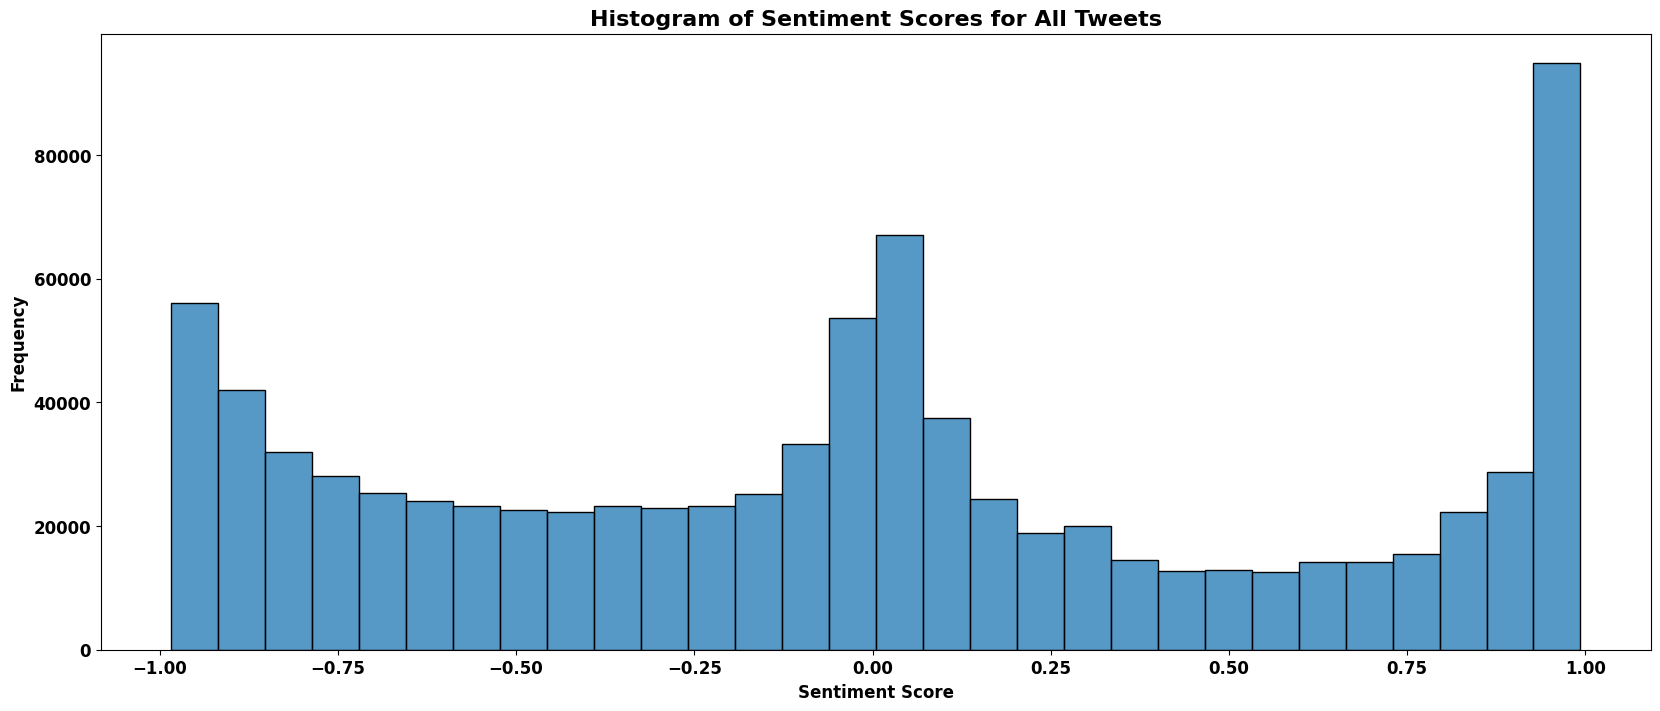

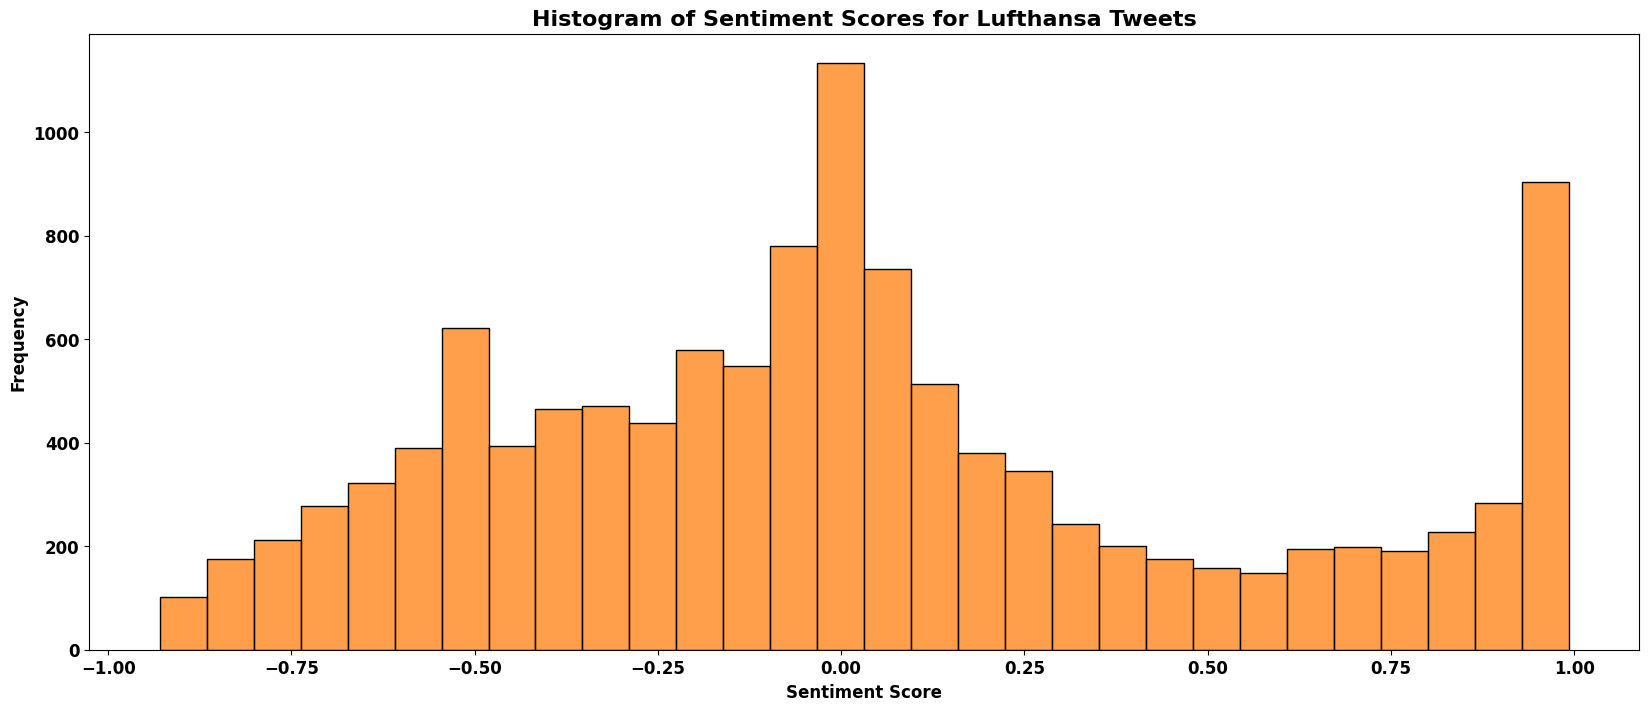

In [32]:
def process_sentiment_scores(df, user_id=None):
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    
    if user_id:
        df = df[df['user_id'] == user_id].copy()
    
    return df['sentiment_score'].dropna()

# Define a function to plot the histogram
def plot_histogram(data, title, xlabel, ylabel, color):
    plt.figure(figsize=(20, 8))
    sns.histplot(data, bins=30, color=color, kde=False)
    
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.show()

# Define colormap
cmap = mcolors.TABLEAU_COLORS

# Process and plot the data for all tweets
all_sentiment_scores = process_sentiment_scores(df_reset)
plot_histogram(all_sentiment_scores, 'Histogram of Sentiment Scores for All Tweets', 'Sentiment Score', 'Frequency', list(cmap.values())[0])

# Process and plot the data for Lufthansa tweets
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_sentiment_scores = process_sentiment_scores(df_reset, user_id=lufthansa_user_id)
plot_histogram(lufthansa_sentiment_scores, 'Histogram of Sentiment Scores for Lufthansa Tweets', 'Sentiment Score', 'Frequency', list(cmap.values())[1])

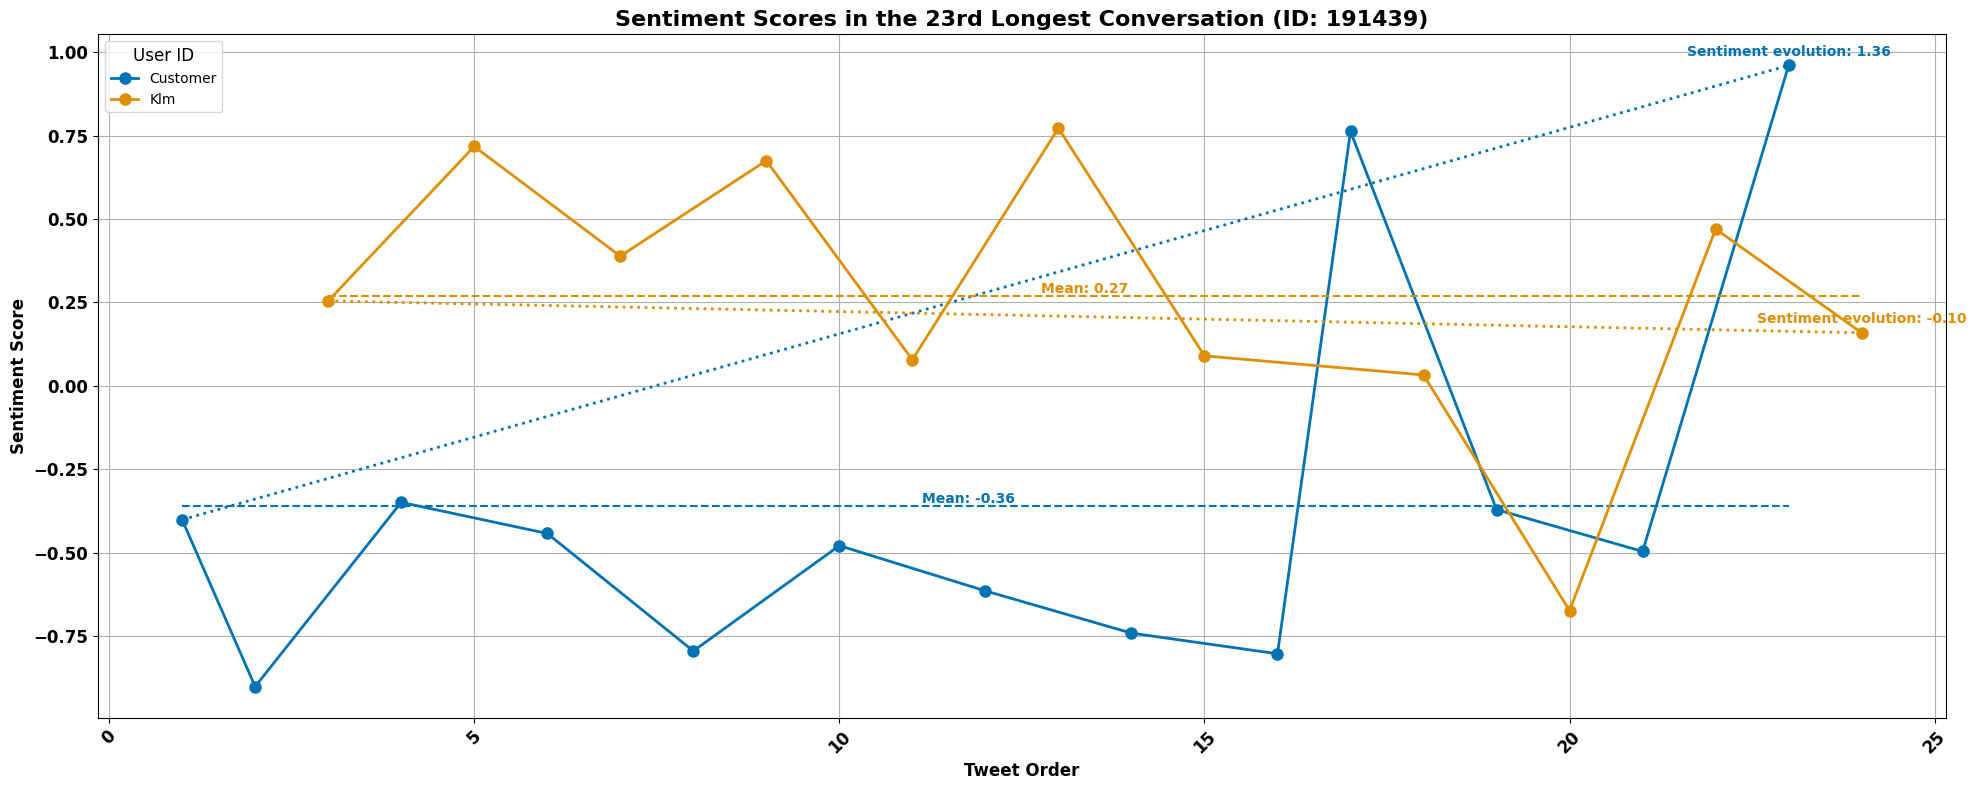

In [33]:
# Ensure tweet_creation_time and sentiment_score are in the correct format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Find and extract the nth longest conversation
nth = 23
conversation_lengths = df_reset['conversation_id'].value_counts()
nth_longest_conversation_id = conversation_lengths.index[nth - 1]
nth_longest_conversation_tweets = df_reset[df_reset['conversation_id'] == nth_longest_conversation_id].sort_values('tweet_order')

# Define color palette and map user_id to colors
palette = sns.color_palette("colorblind", n_colors=nth_longest_conversation_tweets['user_id'].nunique())
user_color_map = {user: palette[i] for i, user in enumerate(nth_longest_conversation_tweets['user_id'].unique())}
nth_longest_conversation_tweets['color'] = nth_longest_conversation_tweets['user_id'].map(user_color_map)

# Calculate average sentiment score for each user
avg_sentiment_scores = nth_longest_conversation_tweets.groupby('user_id')['sentiment_score'].mean()

# Plot the scatter plot with lines connecting dots for each user
plt.figure(figsize=(20, 8))
for user_id, group in nth_longest_conversation_tweets.groupby('user_id'):
    color = user_color_map[user_id]
    avg_sentiment = avg_sentiment_scores[user_id]
    first_last_diff = group['sentiment_score'].iloc[-1] - group['sentiment_score'].iloc[0]

    plt.plot(group['tweet_order'], group['sentiment_score'], color=color, label=COMPANY_ID_TO_NAME.get(user_id, "Customer"), marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.hlines(avg_sentiment, xmin=group['tweet_order'].min(), xmax=group['tweet_order'].max(), colors=color, linestyles='dashed')
    plt.plot([group['tweet_order'].min(), group['tweet_order'].max()], [group['sentiment_score'].iloc[0], group['sentiment_score'].iloc[-1]], color=color, linestyle='dotted', linewidth=2)

    plt.text(group['tweet_order'].mean(), avg_sentiment, f'Mean: {avg_sentiment:.2f}', color=color, fontsize=10, weight='bold', ha='center', va='bottom')
    plt.text(group['tweet_order'].max(), group['sentiment_score'].iloc[-1] + 0.02, f'Sentiment evolution: {first_last_diff:.2f}', color=color, fontsize=10, weight='bold', ha='center', va='bottom')

plt.xlabel('Tweet Order', fontsize=12, weight='bold')
plt.ylabel('Sentiment Score', fontsize=12, weight='bold')
plt.title(f'Sentiment Scores in the {nth}rd Longest Conversation (ID: {nth_longest_conversation_id})', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(title='User ID', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# Group by 'Conversation' and 'user_id' to get the first and last sentiment scores
grouped = df_reset.groupby(['conversation_id', 'user_id'])

# Calculate the first and last sentiment scores
first_last_sentiments = grouped['sentiment_score'].agg(['first', 'last']).reset_index()

# Calculate the change in sentiment score
first_last_sentiments['change_in_sentiment'] = first_last_sentiments['last'] - first_last_sentiments['first']
# df_conversations_full = df_conversations_full.merge(first_last_sentiments[['Conversation', 'user_id', 'change_in_sentiment']], on=['Conversation', 'user_id'], how='left')
def categorize_sentiment_change(change):
    if change > 0:
        return 'Positive'
    elif change < 0:
        return 'Negative'
    else:
        return 'Neutral'

average_sentiment_per_user = df_reset.groupby(['conversation_id', 'user_id']).agg(
    tweets_number=("sentiment_score", "count"),
    average_sentiment=("sentiment_score", "mean"),
    min_sentiment=("sentiment_score", "min"),
    max_sentiment=("sentiment_score", "max"),
    first_tweet=("tweet_creation_time", "min")
).reset_index()

# Merge first_last_sentiments with average_sentiment_per_user
merged_df = pd.merge(average_sentiment_per_user, first_last_sentiments[['conversation_id', 'user_id', 'change_in_sentiment']],
                     on=['conversation_id', 'user_id'], how='left')
merged_df['sentiment_trend'] = merged_df['change_in_sentiment'].apply(categorize_sentiment_change)
merged_df["airline"] = merged_df["user_id"].map(COMPANY_ID_TO_NAME)

C:\Users\Chekm\AppData\Local\Temp\ipykernel_20400\363632716.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be

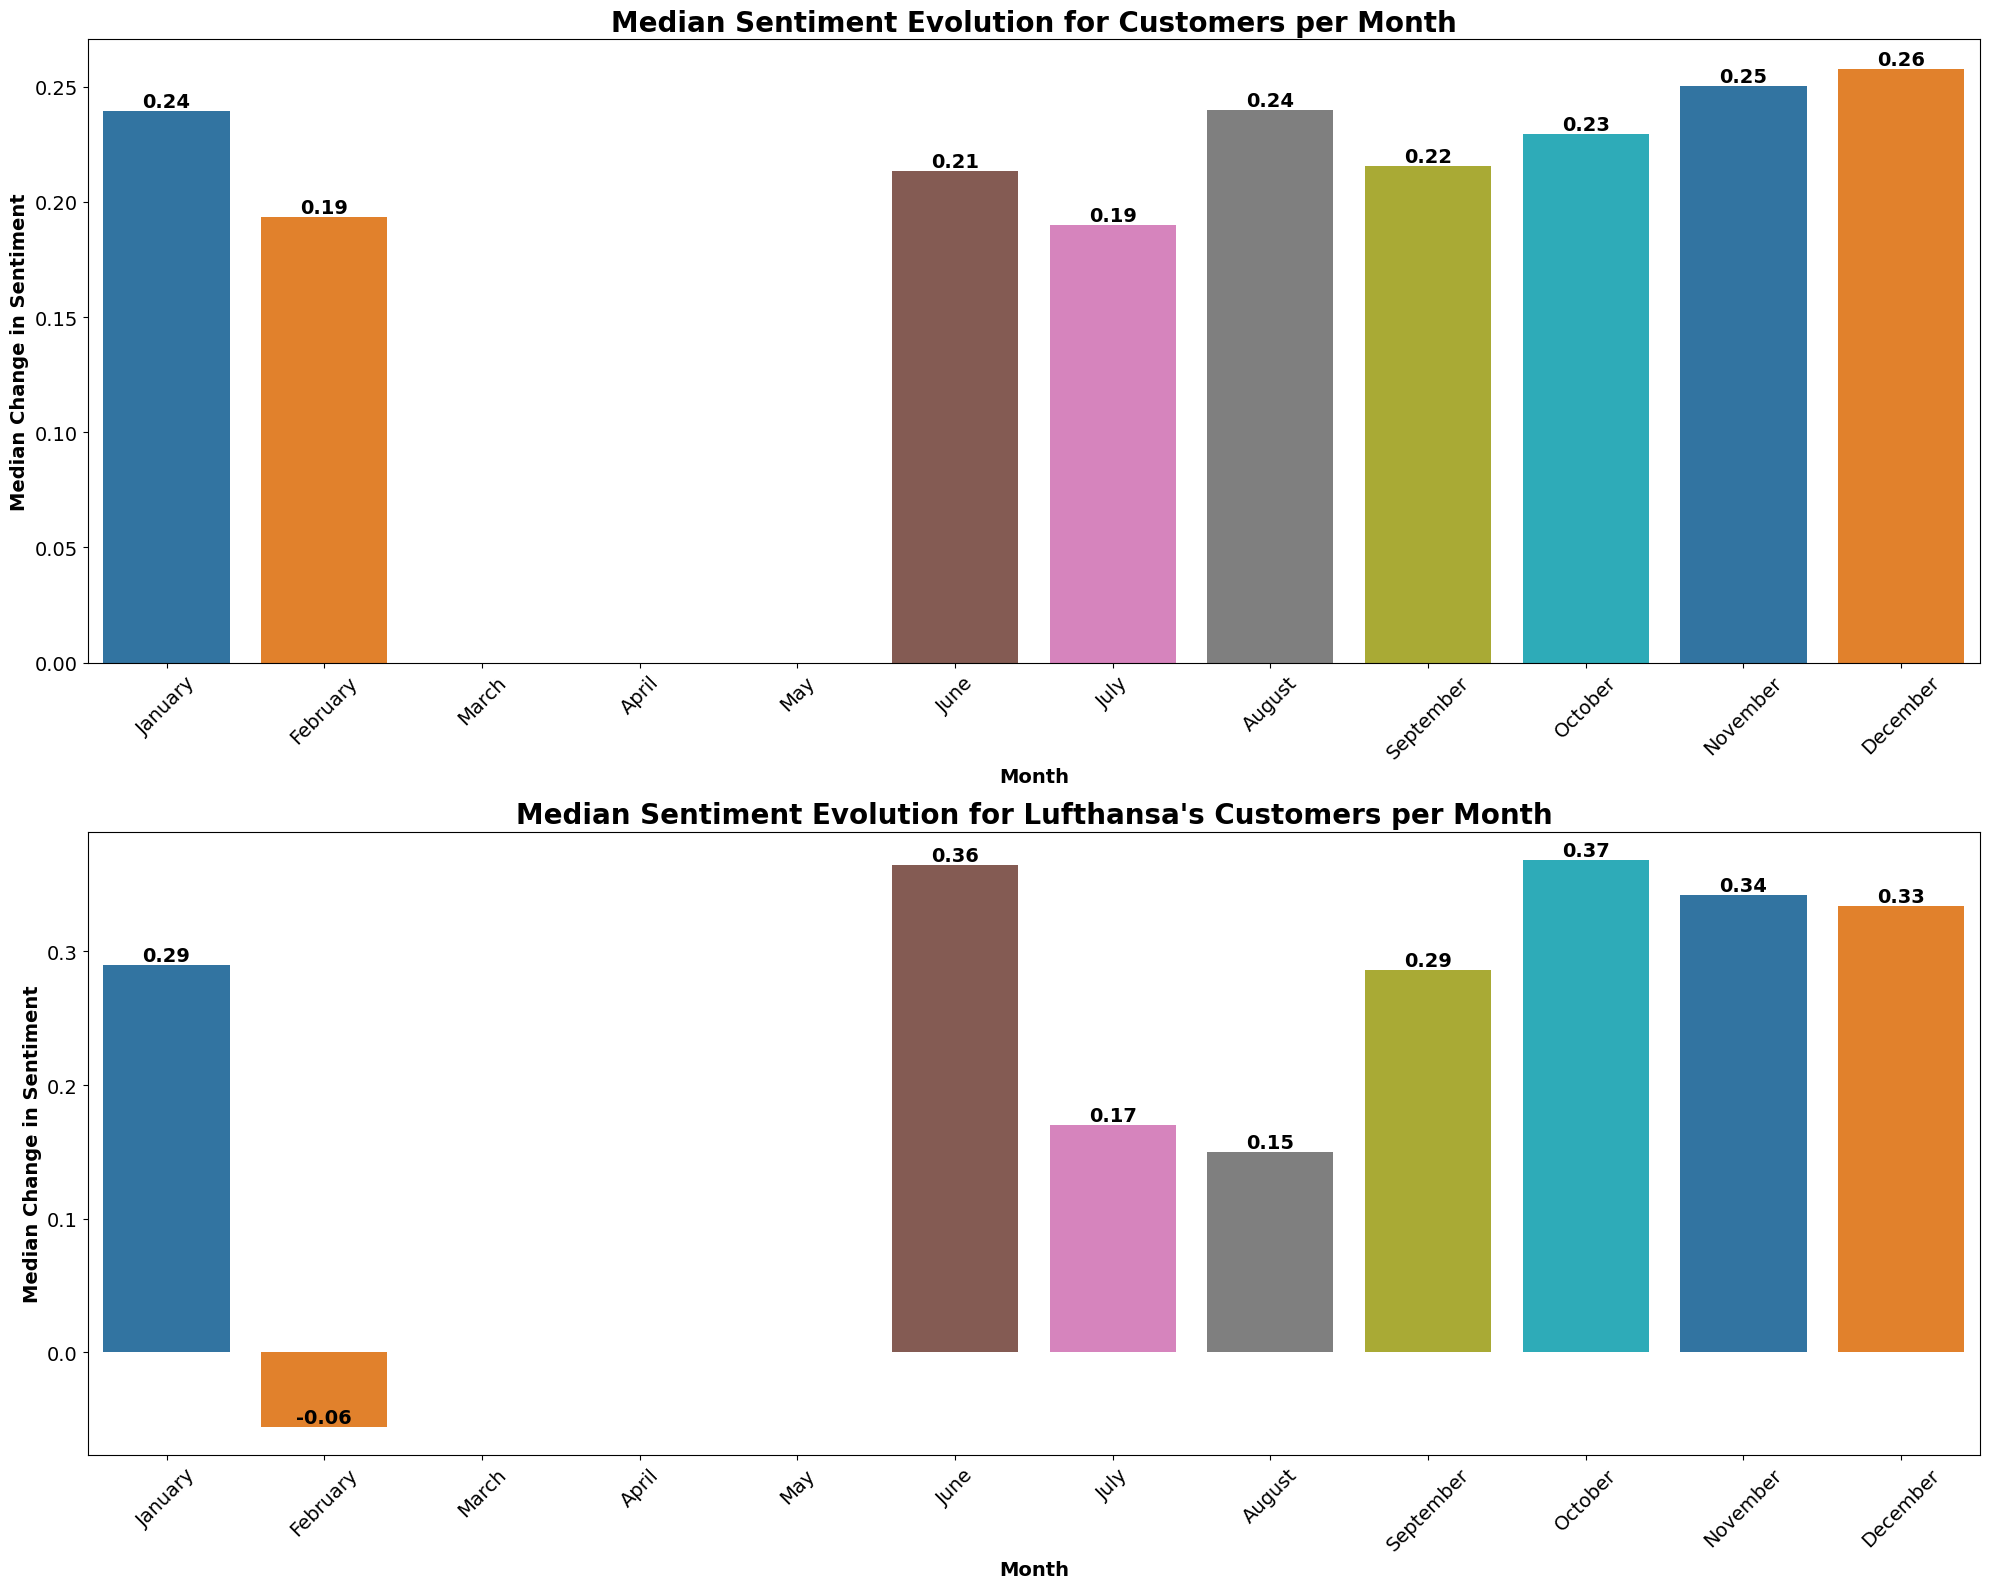

In [35]:
# Convert first_tweet to datetime if not already done
merged_df['first_tweet'] = pd.to_datetime(merged_df['first_tweet'])

# Identify customer tweets (tweets not from airlines)
customer_tweets = merged_df[merged_df['airline'].isna()]

# Filter conversations with more than 2 customer tweets
valid_customer_tweets = customer_tweets.query("tweets_number > 2")

# Extract the month from tweet creation time
valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')

# Calculate the median sentiment evolution per conversation
median_sentiment_evolution = valid_customer_tweets.groupby('conversation_id')['change_in_sentiment'].median().reset_index()

# Merge with the month information
valid_customer_tweets = valid_customer_tweets[['conversation_id', 'month']].drop_duplicates()
median_sentiment_evolution = median_sentiment_evolution.merge(valid_customer_tweets, on='conversation_id')

# Calculate the median sentiment change per month
median_sentiment_per_month = median_sentiment_evolution.groupby('month')['change_in_sentiment'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Filter conversations involving Lufthansa
lufthansa_conversations = merged_df[merged_df['airline'] == 'Lufthansa']['conversation_id'].unique()

# Identify customer tweets in conversations where Lufthansa is participating
customer_tweets_lufthansa = merged_df[merged_df['conversation_id'].isin(lufthansa_conversations) & merged_df['airline'].isna()]

# Filter conversations with more than 2 customer tweets
valid_customer_tweets_lufthansa = customer_tweets_lufthansa.query("tweets_number > 2").copy()

# Extract the month from tweet creation time
valid_customer_tweets_lufthansa['month'] = valid_customer_tweets_lufthansa['first_tweet'].dt.strftime('%B')

# Calculate the median sentiment evolution per conversation
median_sentiment_evolution_lufthansa = valid_customer_tweets_lufthansa.groupby('conversation_id')['change_in_sentiment'].median().reset_index()

# Merge with the month information
valid_customer_tweets_lufthansa = valid_customer_tweets_lufthansa[['conversation_id', 'month']].drop_duplicates()
median_sentiment_evolution_lufthansa = median_sentiment_evolution_lufthansa.merge(valid_customer_tweets_lufthansa, on='conversation_id')

# Calculate the median sentiment change per month
median_sentiment_per_month_lufthansa = median_sentiment_evolution_lufthansa.groupby('month')['change_in_sentiment'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a color palette using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 16))

# First plot: Median Sentiment Evolutions of Customer Tweets per Month
sns.barplot(ax=axs[0], x=median_sentiment_per_month.index, y=median_sentiment_per_month.values, palette=colors)
axs[0].set_xlabel('Month', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Median Change in Sentiment', fontsize=14, fontweight='bold')
axs[0].set_title('Median Sentiment Evolution for Customers per Month', fontsize=20, fontweight='bold')
axs[0].tick_params(axis='x', rotation=45, labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)

# Add numerical values on top of each bar
for index, value in enumerate(median_sentiment_per_month.values):
    axs[0].text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Second plot: Median Sentiment Evolution of Customer Tweets in Conversations with Lufthansa per Month
sns.barplot(ax=axs[1], x=median_sentiment_per_month_lufthansa.index, y=median_sentiment_per_month_lufthansa.values, palette=colors)
axs[1].set_xlabel('Month', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Median Change in Sentiment', fontsize=14, fontweight='bold')
axs[1].set_title("Median Sentiment Evolution for Lufthansa's Customers per Month", fontsize=20, fontweight='bold')
axs[1].tick_params(axis='x', rotation=45, labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

# Add numerical values on top of each bar
for index, value in enumerate(median_sentiment_per_month_lufthansa.values):
    axs[1].text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()

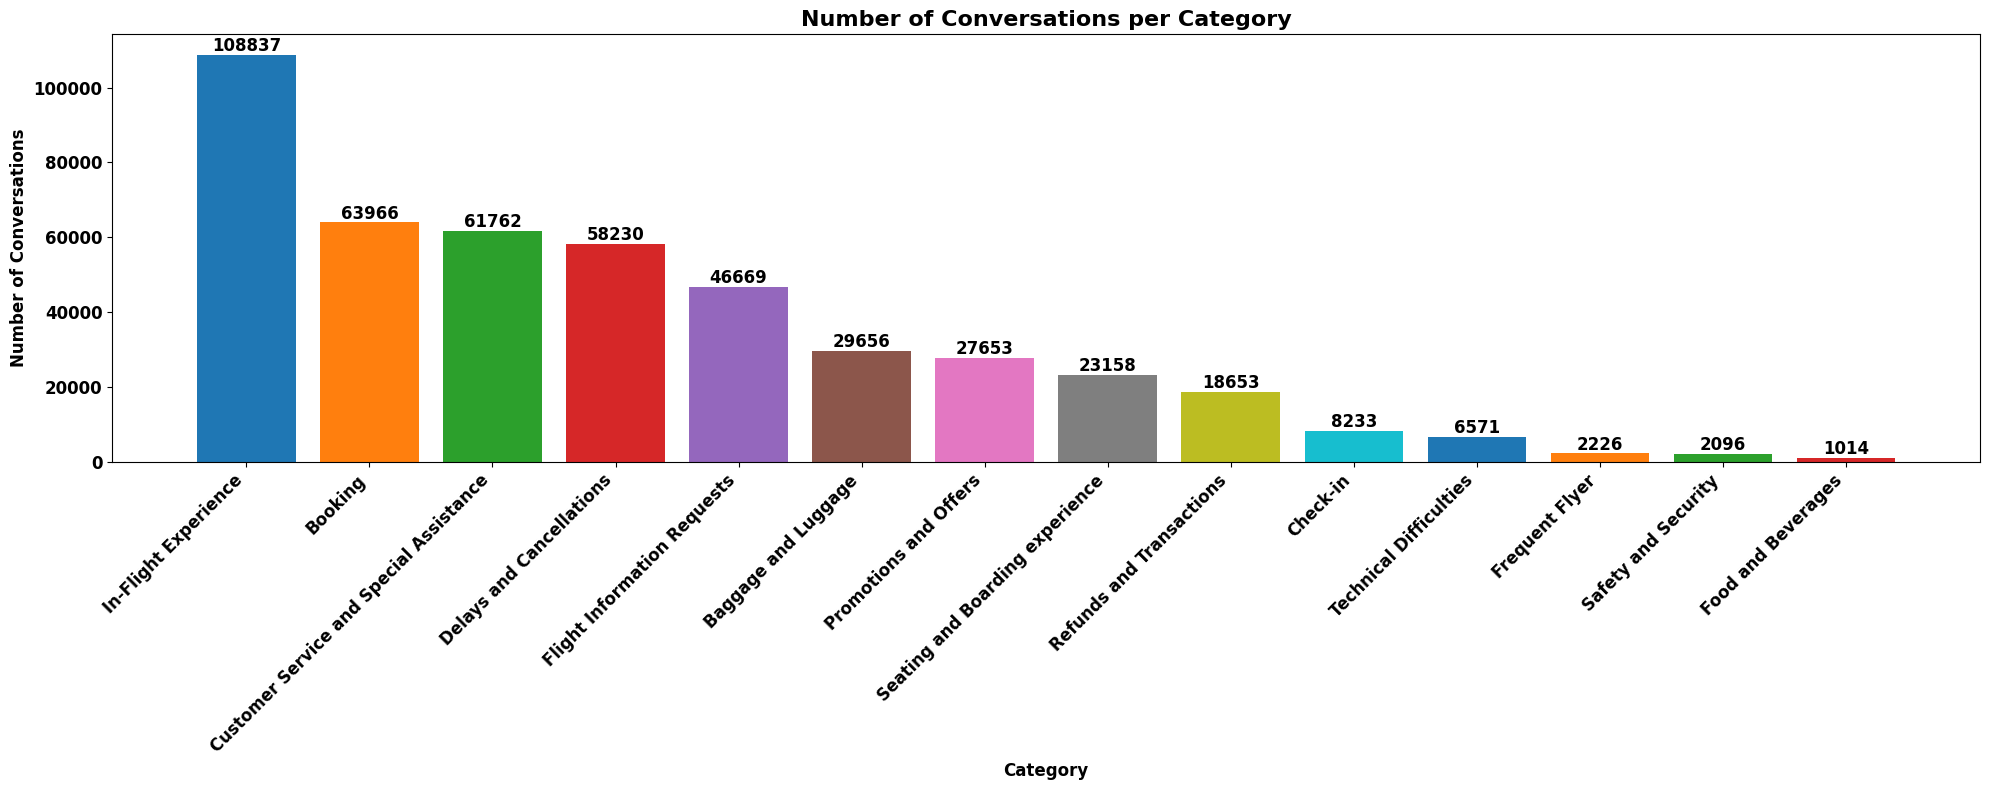

In [36]:
# Calculate the category counts
category_counts = df_conversations_category.groupby('category').size().sort_values(ascending=False)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

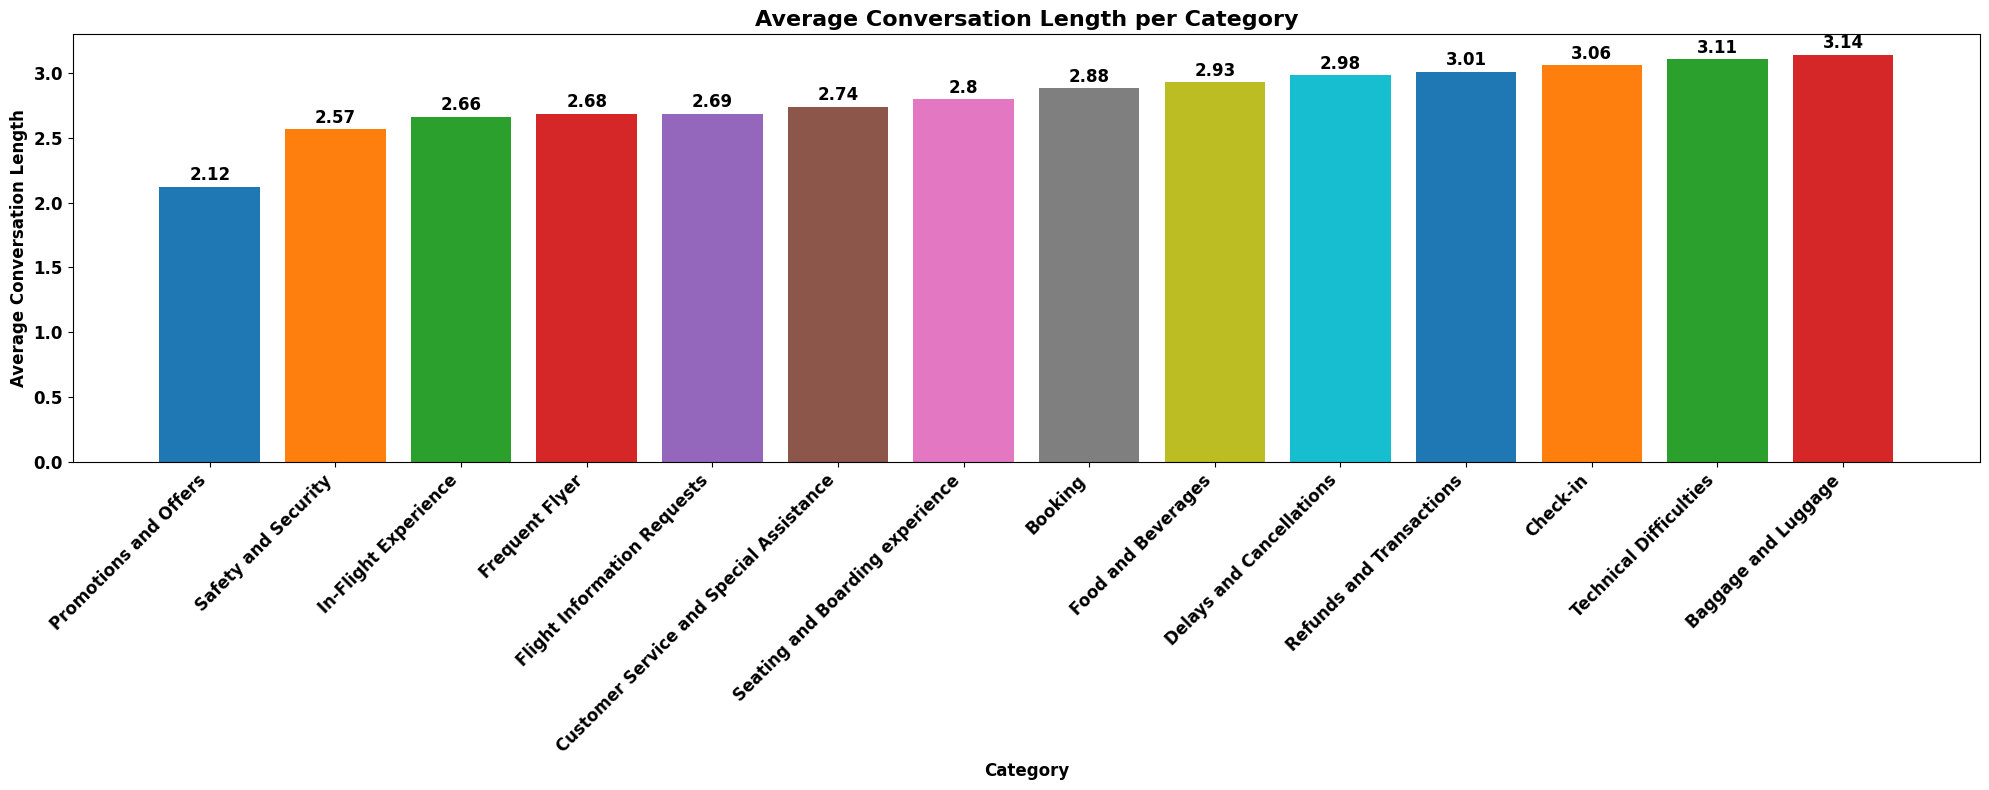

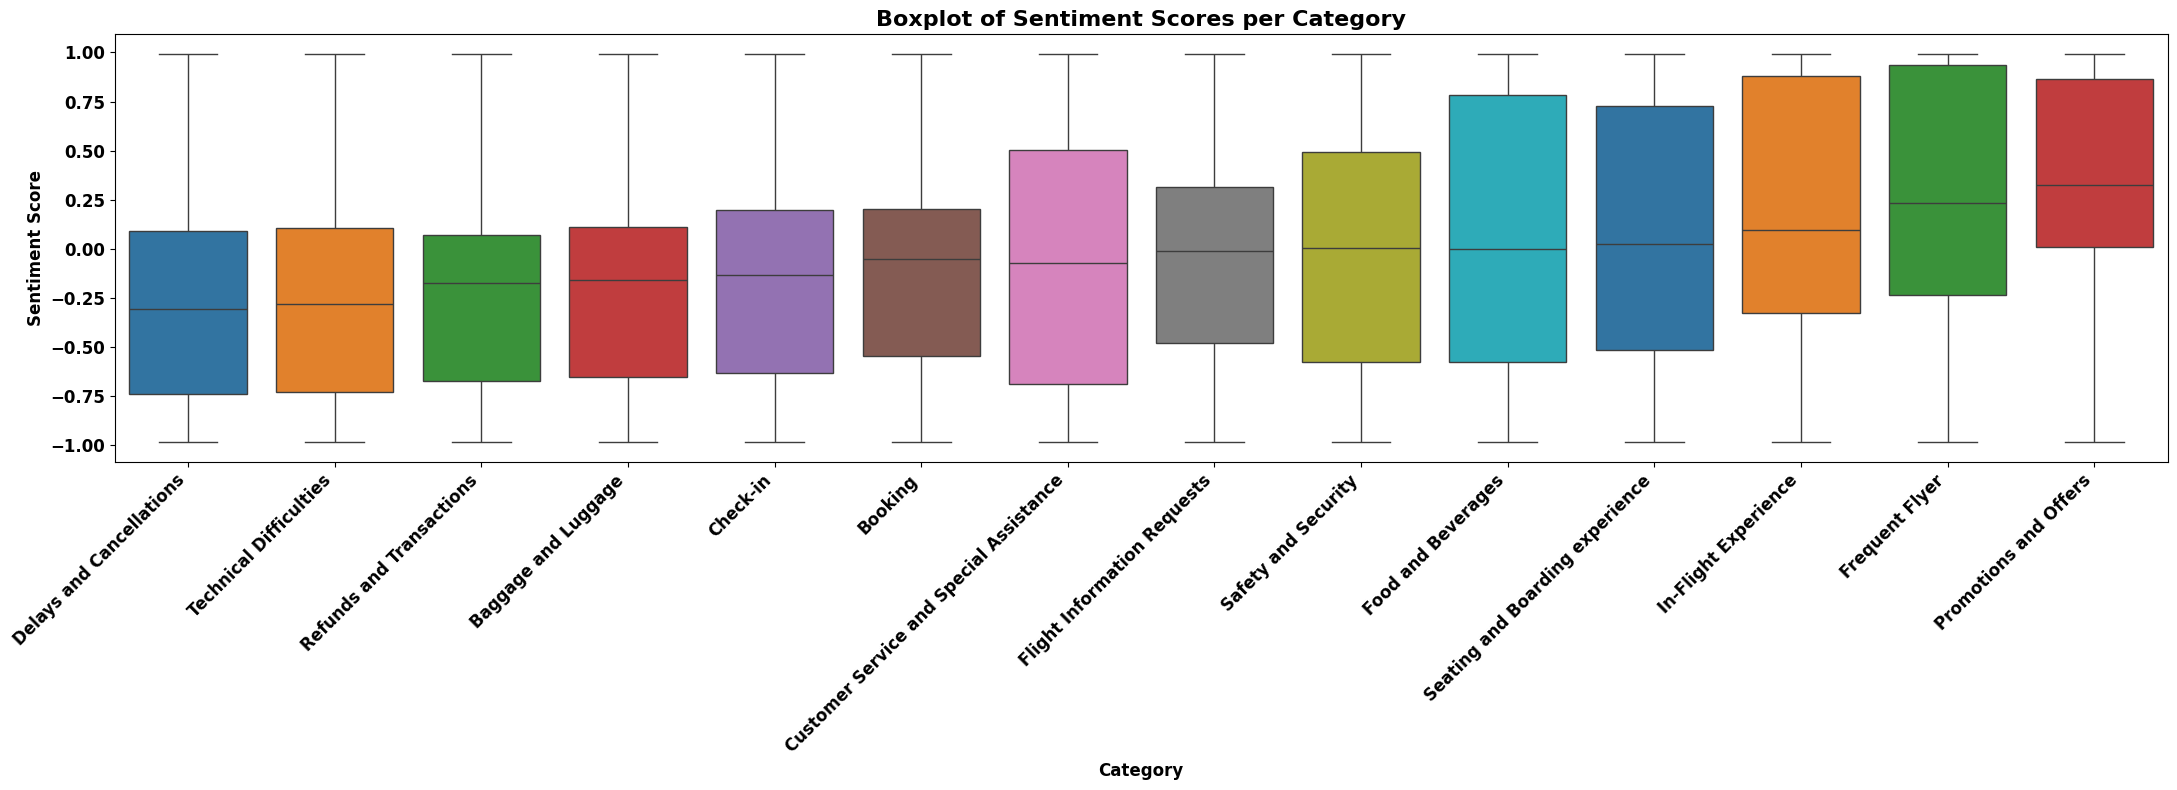

In [37]:
# Define a function to plot the bar chart
def plot_bar_chart(data, x, y, title, xlabel, ylabel, label_offset=0.01, colors=None):
    plt.figure(figsize=(20, 8))
    bars = plt.bar(data[x], data[y], color=colors[:len(data[x])])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
    plt.yticks(fontsize=12, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + label_offset, round(yval, 2) if isinstance(yval, float) else int(yval), ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Define a function to plot the box plot
def plot_box_plot(data, x, y, title, xlabel, ylabel, order, palette):
    plt.figure(figsize=(22, 8))
    sns.boxplot(x=x, y=y, data=data, order=order, palette=palette)
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Define colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# 1st Plot: Number of Conversations per Category
# category_counts = df_conversations_category['category'].value_counts()
# plot_bar_chart(category_counts.reset_index(), 'count', 'category', 'Number of Conversations per Category', 'Category', 'Number of Conversations', label_offset=1000, colors=colors)

# 2nd Plot: Average Conversation Length per Category
conversation_lengths = df_reset.groupby('conversation_id').size().reset_index(name='conversation_length')
together = pd.merge(conversation_lengths, df_conversations_category, on='conversation_id')
avg_conversation_length_per_category = together.groupby('category')['conversation_length'].mean().sort_values()
plot_bar_chart(avg_conversation_length_per_category.reset_index(), 'category', 'conversation_length', 'Average Conversation Length per Category', 'Category', 'Average Conversation Length', label_offset=0.05, colors=colors)

# 3rd Plot: Boxplot of Sentiment Scores per Category
to_plot = pd.merge(df_reset, df_conversations_category, on='conversation_id')
average_sentiment_per_category = to_plot.groupby('category')['sentiment_score'].mean()
sorted_categories = average_sentiment_per_category.sort_values().index
plot_box_plot(to_plot, 'category', 'sentiment_score', 'Boxplot of Sentiment Scores per Category', 'Category', 'Sentiment Score', sorted_categories, colors[:len(sorted_categories)])

# Demo

In [38]:
df_tweets["lang"] = df_tweets["lang"].apply(get_full_language_name)
df_tweets["country_code"] = df_tweets["country_code"].apply(get_country_name)

In [39]:
df_all = pd.merge(df_conversations, df_tweets_and_users, left_on='tweet_id', right_index=True, how='inner')
df_all['airline_name'] = df_all['user_id'].map(COMPANY_ID_TO_NAME)
df_all['user_type'] = np.where(df_all['airline_name'].isna(), 'User', 'Airline')

In [40]:
df_user_sentiment = pd.DataFrame()

df_conversations_category["conversation_length"] = df_all.groupby("conversation_id").size()
df_conversations_category["conversation_start_time"] = df_all.groupby("conversation_id").first()["tweet_creation_time"]
df_conversations_category["conversation_end_time"] = df_all.groupby("conversation_id").last()["tweet_creation_time"]

user_tweets = df_all[df_all['user_type'] == 'User'].groupby("conversation_id")
df_conversations_category["user_sentiment_evolution"] = user_tweets.first()["sentiment_score"] - user_tweets.last()["sentiment_score"]
df_conversations_category["user_sentiment_min"] = user_tweets['sentiment_score'].min()
df_conversations_category["user_sentiment_max"] = user_tweets['sentiment_score'].max()
df_conversations_category["user_sentiment_mean"] = user_tweets['sentiment_score'].mean()
airline_tweets = df_all[df_all['user_type'] == 'Airline'].groupby("conversation_id")
df_conversations_category["airline_name"] = airline_tweets.first()["airline_name"]
df_conversations_category["airline_sentiment_evolution"] = airline_tweets.first()["sentiment_score"] - airline_tweets.last()["sentiment_score"]
df_conversations_category["airline_sentiment_min"] = airline_tweets['sentiment_score'].min()
df_conversations_category["airline_sentiment_max"] = airline_tweets['sentiment_score'].max()
df_conversations_category["airline_sentiment_mean"] = airline_tweets['sentiment_score'].mean()

In [41]:
df_reset = df_all.join(df_conversations_category.drop("airline_name", axis=1), on="conversation_id")
df_reset.size

27774784

In [42]:
def calculate_first_response_time_fast(df):
    # Check if all required columns are present
    required_columns = ['user_type', 'tweet_creation_time']
    for column in required_columns:
        if column not in df.columns:
            raise KeyError(f"DataFrame is missing required column: {column}")

    # Reset index to access conversation_id and tweet_order
    df_reset = df.reset_index()

    # Sort the dataframe by 'conversation_id' and 'tweet_order' for efficiency
    df_sorted = df_reset.sort_values(by=['conversation_id', 'tweet_order'])

    # Get the first user tweet time for each conversation
    first_user_tweets = df_sorted[df_sorted['user_type'] == 'User'].drop_duplicates('conversation_id', keep='first')
    first_user_tweets = first_user_tweets[['conversation_id', 'tweet_order', 'tweet_creation_time']]
    first_user_tweets.columns = ['conversation_id', 'first_user_tweet_order', 'first_user_tweet_time']

    # Merge first user tweet info back to the original dataframe
    df_merged = pd.merge(df_sorted, first_user_tweets, on='conversation_id', how='left', suffixes=('', '_first_user'))

    # Filter for airline tweets that come after the first user tweet in each conversation
    df_airline = df_merged[(df_merged['user_type'] == 'Airline') & 
                           (df_merged['tweet_order'] > df_merged['first_user_tweet_order'])]

    # Get the first airline tweet after the first user tweet for each conversation
    first_airline_tweets = df_airline.drop_duplicates('conversation_id', keep='first')

    # Calculate response times
    first_airline_tweets['response_time'] = (
        first_airline_tweets['tweet_creation_time'] - first_airline_tweets['first_user_tweet_time']
    ).dt.total_seconds() / 60

    return first_airline_tweets.set_index('conversation_id')[
        ['response_time']
    ]

df_conversations_category["response_time"] = calculate_first_response_time_fast(df_reset)

C:\Users\Chekm\AppData\Local\Temp\ipykernel_20400\1840844912.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_airline_tweets['response_time'] = (


In [43]:
df_lufthansa_conversations_category = df_conversations_category.query("airline_name == 'Lufthansa'").drop("airline_name", axis=1)
double_reset = df_reset.reset_index()
df_lufthansa_reset = double_reset[double_reset['conversation_id'].isin(df_lufthansa_conversations_category.index)].set_index(["conversation_id", "tweet_order"])


In [44]:
# Convert the start and end dates to tz-naive datetime objects
start_date_csv = pd.to_datetime(start_date).tz_localize(None)
end_date_csv = pd.to_datetime(end_date).tz_localize(None)

# Load the no_conversation CSV, parse the dates, and ensure they are timezone-naive
df_no_conversation = pd.read_csv(
    "no_conversation.csv",
    dtype={"user_id": "object"},
    index_col=["tweet_id"],
    parse_dates=["creation_time"]
)

# Ensure the 'creation_time' column is timezone-naive
df_no_conversation['creation_time'] = df_no_conversation['creation_time'].dt.tz_localize(None)

# Filter the DataFrame based on the date range
df_no_conversation = df_no_conversation.query('creation_time >= @start_date_csv and creation_time <= @end_date_csv')

# Rename the 'creation_time' column and merge with df_users DataFrame
df_no_conversation = df_no_conversation.rename(columns={'creation_time': 'tweet_creation_time'}).merge(
    df_users.rename(columns={'creation_time': 'user_creation_time'}),
    left_on='user_id', right_index=True, how='inner'
)

# Apply the get_full_language_name and get_country_name functions
df_no_conversation["lang"] = df_no_conversation["lang"].apply(get_full_language_name)
df_no_conversation["country_code"] = df_no_conversation["country_code"].apply(get_country_name)

In [45]:
user_tweets = df_lufthansa_conversations_category[["category", "user_sentiment_evolution"]].copy()

# Categorize sentiment evolution
user_tweets['sentiment_type'] = user_tweets['user_sentiment_evolution'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)

# Aggregate the data
sentiment_counts = user_tweets.groupby(['category', 'sentiment_type']).size().unstack(fill_value=0)

# Normalize the counts to percentages
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sort the categories by the percentage of negative sentiment
sentiment_percentages = sentiment_percentages.sort_values(
    by=["Negative", "Neutral", "Positive"]
)

# Create the Plotly stacked bar chart
fig = go.Figure()

# Define colors for each sentiment type
colors = {
    'Positive': '#00CC96',
    'Neutral': '#636EFA',
    'Negative': '#FF7F09'
}

# Add a bar trace for each sentiment type
for sentiment in sentiment_percentages.columns:
    fig.add_trace(
        go.Bar(
            y=sentiment_percentages.index,
            x=sentiment_percentages[sentiment],
            name=sentiment,
            text=(sentiment_percentages[sentiment] * 100).round(2).astype(str) + '%',
            textposition='inside',
            marker_color=colors[sentiment],
            orientation='h',
            textfont={"size": 16}
        )
    )

# Update the layout
fig.update_layout(
    barmode='stack',
    title={
        "text": "Normalised Stacked Bar Chart of User Sentiment Evolution per Category",
        "font": {"size": 28}
    },
    xaxis_title={"text": 'Percentage of Conversations', "font": {"size": 18}},
    yaxis={"tickfont": {"size": 18}},
    xaxis={"tickfont": {"size": 18}},
    xaxis_tickformat=".0%",
    width=1150,
    height=700,
    margin=dict(l=20, r=20, t=80, b=20),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1,
        xanchor="center",
        x=0.5,
        font={"size": 18},
    )
)

In [46]:
tweet_counts = df_no_conversation['category'].value_counts().sort_values(ascending=False)

# Calculate the number of conversations per category
conversation_counts = df_lufthansa_conversations_category['category'].value_counts().reindex(tweet_counts.index, fill_value=0)

# Combine the counts into a single DataFrame
combined_counts = pd.DataFrame({
    'Unanswered Tweets': tweet_counts,
    'Conversations': conversation_counts
})

# Normalize the counts to percentages by each column total
combined_counts_normalized = combined_counts.div(combined_counts.sum(axis=0), axis=1) * 100

# Create the subplots figure with shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    subplot_titles=('Percentage of Conversations and Non-Responded Tweets per Category', 
                                    'Sentiment Score Distribution of Non-Responded Tweets per Category'),
                    vertical_spacing=0.05)

# Add the grouped bar chart for number of tweets and conversations per category
fig.add_trace(go.Bar(
    x=combined_counts_normalized.index,
    y=combined_counts_normalized['Unanswered Tweets'],
    text=combined_counts_normalized['Unanswered Tweets'].round(2).astype(str) + '%',
    textposition='inside',
    name='Unanswered Tweets',
    marker_color='#636EFA'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=combined_counts_normalized.index,
    y=combined_counts_normalized['Conversations'],
    text=combined_counts_normalized['Conversations'].round(2).astype(str) + '%',
    textposition='inside',
    name='Conversations',
    marker_color='orange'
), row=1, col=1)

# Add a box trace for each category, sorted by number of tweets in ascending order
for category in tweet_counts.index:
    fig.add_trace(go.Box(
        y=df_no_conversation[df_no_conversation['category'] == category]["sentiment_score"],
        name=category,
        boxmean=True,  # Shows the mean line in the box plot
        showlegend=False  # Remove category from legend
    ), row=2, col=1)

user_tweets = df_lufthansa_conversations_category.query("user_sentiment_evolution != 0")[["category", "user_sentiment_mean"]]

# Calculate the median sentiment score for each category and sort the categories
category_medians = user_tweets.groupby("category")["user_sentiment_mean"].median().sort_values()

# Calculate the median of medians
median_of_medians = category_medians.median()

fig.add_trace(go.Scatter(
    x=category_medians.index,
    y=[median_of_medians] * len(category_medians),
    mode='lines',
    name='Median of Sentiment Evolution for Current Conversations',
    line=dict(color='orange', dash='dash')
), row=2, col=1)

# Update the layout
fig.update_layout(
    barmode='group',
    yaxis=dict(title='Percentage of Tweets or Conversations', tickfont=dict(size=18)),
    yaxis2=dict(title='Sentiment Score', tickfont=dict(size=18)),
    width=1100,
    height=1000,
    showlegend=True, 
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.9,
        orientation="v"
    ),
    title_font_size=32,
    font=dict(size=16),  # Set the font size for subplot titles
    margin=dict(l=20, r=20, t=40, b=20)  # Tight layout with no extra whitespace
)

# Update subplot titles font size
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=24)

# Show the plot
fig.show()


In [47]:
user_tweets = df_conversations_category.query("conversation_length > 2")[["airline_name", "user_sentiment_evolution"]].copy()

# Categorize sentiment evolution
user_tweets['sentiment_type'] = user_tweets['user_sentiment_evolution'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)

# Aggregate the data
sentiment_counts = user_tweets.groupby(['airline_name', 'sentiment_type']).size().unstack(fill_value=0)

# Normalize the counts to percentages
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sort the categories by the percentage of negative sentiment
sentiment_percentages = sentiment_percentages.sort_values(
    by=["Positive", "Neutral", "Negative"]
)

# Create the Plotly stacked bar chart
fig = go.Figure()

# Define colors for each sentiment type
colors = {
    'Positive': '#00CC96',
    'Negative': '#FF7F09',
    'Neutral': '#636EFA',
}

# Add a bar trace for each sentiment type
for sentiment in sentiment_percentages.columns:
    fig.add_trace(
        go.Bar(
            x=sentiment_percentages.index,
            y=sentiment_percentages[sentiment],
            name=sentiment,
            text=(sentiment_percentages[sentiment] * 100).round(1).astype(str) + '%',
            textposition='inside',
            marker_color=colors[sentiment],
            textfont={"size": 18}
        )
    )

# Update the layout
fig.update_layout(
    barmode='stack',
    title={
        "text": "Normalised Stacked Bar Chart of User Sentiment Evolution per Airline<br>(with conversation length > 2)",
        "font": {"size": 24},
        "x": 0.05,
        "xanchor": "left",
        "yanchor": "top"
    },
    yaxis_title={"text": 'Percentage of Conversations', "font": {"size": 18}},
    xaxis={"tickfont": {"size": 18}},
    yaxis={"tickfont": {"size": 18}},
    yaxis_tickformat=".0%",
    width=1100,
    height=530,
    legend=dict(
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        orientation="h",
        font=dict(size=18)
    ),
    margin=dict(l=20, r=20, t=80, b=20)  # Adjust the margin as needed
)

In [48]:
unique_no_conversation_users = df_no_conversation.drop_duplicates(subset='user_id')
unique_lufthansa_users = df_lufthansa_reset.query("user_type == 'User'").drop_duplicates(subset='user_id')

# Combine follower counts from both DataFrames
combined_followers = pd.concat([unique_no_conversation_users['followers_count'], unique_lufthansa_users['followers_count']])

# Calculate the percentiles for the combined follower counts
percentiles = np.linspace(0, 1, 11)
followers_percentiles = combined_followers.quantile(percentiles)

# Define bands using the combined percentiles
unique_no_conversation_users['followers_band'] = pd.cut(
    unique_no_conversation_users['followers_count'],
    bins=followers_percentiles,
    include_lowest=True,
    labels=[f'{int(followers_percentiles.iloc[i])}-{int(followers_percentiles.iloc[i+1])}' for i in range(len(followers_percentiles)-1)]
)

unique_lufthansa_users['followers_band'] = pd.cut(
    unique_lufthansa_users['followers_count'],
    bins=followers_percentiles,
    include_lowest=True,
    labels=[f'{int(followers_percentiles.iloc[i])}-{int(followers_percentiles.iloc[i+1])}' for i in range(len(followers_percentiles)-1)]
)

# Count the number of unique users in each band
user_counts_no_conversation = unique_no_conversation_users['followers_band'].value_counts().sort_index()
user_counts_lufthansa = unique_lufthansa_users['followers_band'].value_counts().sort_index()

# Normalize the counts to percentages
total_no_conversation = user_counts_no_conversation.sum()
total_lufthansa = user_counts_lufthansa.sum()

user_counts_no_conversation_normalized = (user_counts_no_conversation / total_no_conversation) * 100
user_counts_lufthansa_normalized = (user_counts_lufthansa / total_lufthansa) * 100

# Combine the normalized counts into a single DataFrame
combined_counts = pd.DataFrame({
    'Ignored Conversations': user_counts_no_conversation_normalized,
    'Conversations with Lufthansa': user_counts_lufthansa_normalized
}).fillna(0)

# Create the side-by-side bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=combined_counts.index,
    y=combined_counts['Ignored Conversations'],
    name='Unanswered tweets',
    marker_color='indianred',
    text=combined_counts['Ignored Conversations'].round(2).astype(str) + '%',
    textposition='inside',
    textfont={"size": 18},
))

fig.add_trace(go.Bar(
    x=combined_counts.index,
    y=combined_counts['Conversations with Lufthansa'],
    name='Conversations with Lufthansa',
    marker_color='lightsalmon',
    text=combined_counts['Conversations with Lufthansa'].round(2).astype(str) + '%',
    textposition='inside',
    textfont={"size": 18},

))

# Update the layout
fig.update_layout(
    barmode='group',
    title={
        "text": 'Unresponded Tweets and Conversation Distribution per User Followers Count',
        "font": {"size": 24}
    },
    xaxis_title={
        "text": 'User Followers Count',
        "font": {"size": 22}
    },
    yaxis_title={
        "text": 'Percentage of Conversations',
        "font": {"size": 22}
    },
    xaxis={
        "tickfont": {"size": 18}
    },
    yaxis={
        "tickfont": {"size": 18}
    },
    width=1100,
    height=550,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="center",
        x=0.5,
        orientation="h",
        font={"size": 18}
    )
)

fig.show()


C:\Users\Chekm\AppData\Local\Temp\ipykernel_20400\2226413478.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
def calculate_t_score(r, n):
    return r * math.sqrt((n - 2) / (1 - r**2))

# Select relevant columns and drop rows with missing values
for_testing = df_lufthansa_conversations_category[["conversation_length",
                                         "airline_sentiment_min", "airline_sentiment_max", "airline_sentiment_mean",
                                         "response_time",
                                         "user_sentiment_mean", "user_sentiment_evolution"]].dropna()
# Convert all columns to numeric, coercing errors to NaN
for column in for_testing.columns:
    for_testing[column] = pd.to_numeric(for_testing[column], errors='coerce')

# Drop rows with NaN values after conversion
for_testing = for_testing.dropna()

variables = for_testing.columns.difference(['user_sentiment_mean', 'user_sentiment_evolution'])

# Initialize lists to store results
results = []

# Calculate Pearson correlation, t-score, and p-value for each variable
for var in variables:
    for sentiment in ['user_sentiment_mean', 'user_sentiment_evolution']:
        r, p_value = pearsonr(for_testing[sentiment], for_testing[var])
        n = len(for_testing[sentiment])
        t_score = calculate_t_score(r, n)
        results.append({
            'Sentiment': sentiment,
            'Variable': var,
            'Pearson Correlation': r,
            'P-value': p_value,
            'T-score': t_score
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


# Create summary table
summary_table = results_df.pivot(index='Variable', columns='Sentiment', values=['Pearson Correlation', 'P-value']).round(5)

summary_table


Pearson Correlation                      \
Sentiment              user_sentiment_evolution user_sentiment_mean   
Variable                                                              
airline_sentiment_max                  -0.02206             0.50403   
airline_sentiment_mean                  0.03276             0.56369   
airline_sentiment_min                   0.08281             0.55269   
conversation_length                    -0.19629            -0.09507   
response_time                           0.01099            -0.01765   

                                        P-value                      
Sentiment              user_sentiment_evolution user_sentiment_mean  
Variable                                                             
airline_sentiment_max                   0.07024             0.00000  
airline_sentiment_mean                  0.00717             0.00000  
airline_sentiment_min                   0.00000             0.00000  
conversation_length                     0.00000             0.00000  
response_time                           0.36737             0.14746

In [50]:
conversation_count = df_lufthansa_conversations_category.shape[0]  # Assuming each row in df_reset represents a conversation
tweet_count = df_no_conversation.shape[0]  # Assuming each row in df_no_conversation represents a tweet

# Create a pie chart with these two values
fig = go.Figure(data=[go.Pie(
    labels=['Proper conversations', 'Not responded by Lufthansa'],
    values=[conversation_count, tweet_count],
    textinfo='label+percent',
    insidetextorientation='radial'
)])

fig.update_layout(
    title={
        "text": "Total Number of Conversations and not responded tweets",
        "font": {"size": 24}
    },
    showlegend=False,
)

In [51]:
category_counts = df_lufthansa_conversations_category["category"].value_counts()

# Get the top 10 categories
top_10_categories = category_counts.head(10)

# Sum the counts of all other categories
other_topics_count = category_counts.iloc[10:].sum()

# Create a Series for "Other topics"
other_topics_series = pd.Series([other_topics_count], index=["Other topics"])

# Concatenate the top 10 categories with the "Other topics" series
top_10_categories_with_other = pd.concat([top_10_categories, other_topics_series])

# Create the Plotly pie chart
fig = go.Figure(data=[go.Pie(
    labels=top_10_categories_with_other.index,
    values=top_10_categories_with_other.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    hole=.2  # Makes it a donut chart to better visualize
)])

# Update the layout
fig.update_layout(
    title={
        "text": 'Number of Conversations per Category In Lufthansa',
        "font": {"size": 24}
    },
    width=1000,
    height=900,
    showlegend=False,
)

In [52]:
avg_conversation_length_per_category = df_lufthansa_conversations_category\
    .groupby("conversation_length").size()

truncate_at = 6
# Aggregate counts for conversation lengths 7 and more into a single category
lengths_to_group = avg_conversation_length_per_category.index[avg_conversation_length_per_category.index >= truncate_at]
grouped_data = avg_conversation_length_per_category.copy()
grouped_data.loc[truncate_at] = grouped_data.loc[lengths_to_group].sum()
grouped_data = grouped_data.drop(lengths_to_group[lengths_to_group != truncate_at])
grouped_data.index = grouped_data.index.astype(str)
grouped_data.index = grouped_data.index.str.replace(f'{truncate_at}', f'{truncate_at}+')

# Create the Plotly pie chart
fig = go.Figure(data=[go.Pie(
    labels=grouped_data.index,
    values=grouped_data.values,
    textinfo='label+percent',
    insidetextorientation='radial'
)])

# Update the layout
fig.update_layout(
    title={
        "text": "Distribution of Lufthansa's Conversations per Their Length",
        "font": {"size": 24}
    },
    width=800,
    height=800
)

In [53]:
conversations_per_airline = df_conversations_category.groupby("airline_name").size()

# Sort the conversation counts
sorted_conversations = conversations_per_airline.sort_values()

# Identify Lufthansa and its neighboring airlines
lufthansa_index = sorted_conversations.index.get_loc('Lufthansa')
neighboring_airlines = []

if lufthansa_index > 0:
    neighboring_airlines.append(sorted_conversations.index[lufthansa_index - 1])
if lufthansa_index < len(sorted_conversations) - 1:
    neighboring_airlines.append(sorted_conversations.index[lufthansa_index + 1])

# Assign colors based on whether the airline is Lufthansa or its neighboring airlines
colors=[]
for airline in sorted_conversations.index:
    if airline == 'Lufthansa':
        colors.append('#00CC96')
    elif airline in neighboring_airlines:
        colors.append('#FF7F09')
    else:
        colors.append('#636EFA')

# Create the Plotly bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_conversations.index,
    y=sorted_conversations.values,
    marker_color=colors,
    text=sorted_conversations.values,
    textposition='outside'
))

# Update the layout
fig.update_layout(
    title={
        "text": "Number of Conversations per Airline",
        "font": {"size": 24}
    },
    xaxis_title={"text": 'Airline', "font": {"size": 18}},
    yaxis_title={"text": 'Number of Conversations', "font": {"size": 18}},
    xaxis_tickangle=-45,
    xaxis={"tickfont": {"size": 14}},
    yaxis={"tickfont": {"size": 14}},
    width=1300,
    height=700
)

In [54]:
# End timing
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")

Total execution time: 85.7394392490387 seconds
